In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression, LinearRegression
import statsmodels.api as sm
from scipy import stats
import doubleml as dml
from sklearn.base import clone
import wbdata
import warnings
warnings.filterwarnings('ignore')

In [15]:
#World values survey data: Wave 7
wvs = pd.read_csv('data/raw_data/WVS_Cross-National_Wave_7_csv_v6_0.csv')

In [16]:
# WVS country mapping
COUNTRY_CODE_MAP = {
    12: 'Algeria', 20: 'Andorra', 31: 'Azerbaijan', 32: 'Argentina', 36: 'Australia',
    50: 'Bangladesh', 51: 'Armenia', 68: 'Bolivia', 76: 'Brazil', 100: 'Bulgaria',
    104: 'Myanmar', 112: 'Belarus', 124: 'Canada', 152: 'Chile', 156: 'China',
    158: 'Taiwan', 170: 'Colombia', 196: 'Cyprus', 203: 'Czech Republic', 208: 'Denmark',
    218: 'Ecuador', 231: 'Ethiopia', 233: 'Estonia', 246: 'Finland', 250: 'France',
    268: 'Georgia', 276: 'Germany', 288: 'Ghana', 300: 'Greece', 320: 'Guatemala',
    344: 'Hong Kong SAR', 348: 'Hungary', 352: 'Iceland', 356:'India', 360: 'Indonesia', 364: 'Iran',
    368: 'Iraq', 372: 'Ireland', 376: 'Israel', 380: 'Italy', 392: 'Japan', 398: 'Kazakhstan',
    400: 'Jordan', 404: 'Kenya', 410: 'South Korea', 417: 'Kyrgyzstan',
    422: 'Lebanon', 458: 'Malaysia', 484: 'Mexico', 496: 'Mongolia', 504: 'Morocco',
    528: 'Netherlands', 558: 'Nicaragua', 566: 'Nigeria', 578: 'Norway', 586:'Pakistan', 604:'Peru', 620: 'Portugal',
    642: 'Romania', 643: 'Russia', 702: 'Singapore', 703: 'Slovakia', 704: 'Vietnam', 705: 'Slovenia', 
    710: 'South Africa', 716: 'Zimbabwe', 724: 'Spain', 764: 'Thailand', 
    788: 'Tunisia', 792: 'Turkey', 804: 'Ukraine', 818: 'Egypt', 826: 'United Kingdom',
    840: 'United States', 860: 'Uzbekistan'
}

#World bank country mapping
WB_TO_WVS = {
    'Algeria': 12, 'Andorra': 20, 'Azerbaijan': 31, 'Argentina': 32, 'Australia': 36,
    'Bangladesh': 50, 'Armenia': 51, 'Bolivia': 68, 'Brazil': 76, 'Bulgaria': 100,
    'Myanmar': 104, 'Belarus': 112, 'Canada': 124, 'Chile': 152, 'China': 156,
    'Taiwan, China': 158, 'Taiwan': 158, 'Colombia': 170, 'Cyprus': 196,
    'Czech Republic': 203, 'Czechia': 203, 'Denmark': 208, 'Ecuador': 218,
    'Ethiopia': 231, 'Estonia': 233, 'Finland': 246, 'France': 250, 'Georgia': 268, 
    'Germany': 276, 'Ghana': 288, 'Greece': 300, 'Guatemala': 320,
    'Hong Kong SAR, China': 344, 'Hong Kong': 344, 'Hungary': 348, 'Iceland': 352,
    'India': 356, 'Indonesia': 360, 'Iran, Islamic Rep.': 364, 'Iran': 364,
    'Iraq': 368, 'Ireland': 372, 'Israel': 376, 'Italy': 380, 'Japan': 392,
    'Kazakhstan': 398, 'Jordan': 400, 'Kenya': 404, 'Korea, Rep.': 410,
    'Korea, Republic of': 410, 'Kyrgyz Republic': 417, 'Kyrgyzstan': 417,
    'Lebanon': 422, 'Malaysia': 458, 'Mexico': 484, 'Mongolia': 496, 'Morocco': 504,
    'Netherlands': 528, 'Nicaragua': 558, 'Nigeria': 566, 'Norway': 578,
    'Pakistan': 586, 'Peru': 604, 'Portugal': 620, 'Romania': 642,
    'Russian Federation': 643, 'Russia': 643, 'Singapore': 702,
    'Slovak Republic': 703, 'Slovakia': 703, 'Vietnam': 704, 'Slovenia': 705,
    'South Africa': 710, 'Zimbabwe': 716, 'Spain': 724, 'Thailand': 764,
    'Tunisia': 788, 'Turkey': 792, 'Ukraine': 804, 'Egypt, Arab Rep.': 818,
    'Egypt': 818, 'United Kingdom': 826, 'United States': 840, 'Uzbekistan': 860
}

In [17]:
# World bank data

indicators = {
    'NY.GDP.PCAP.PP.KD': 'gdp_per_capita_ppp',  
    'SP.URB.TOTL.IN.ZS': 'urban_population_pct', 
    'SP.POP.TOTL': 'population', 
    'SP.DYN.LE00.IN': 'life_expectancy'}

# 2017-2019 (Wave 7)
data_2017 = wbdata.get_dataframe(indicators, date='2017')
data_2018 = wbdata.get_dataframe(indicators, date='2018')
data_2019 = wbdata.get_dataframe(indicators, date='2019')
data_2020 = wbdata.get_dataframe(indicators, date='2020')

# Combine all years adn average
all_years = []
for year, data in [('2017', data_2017), ('2018', data_2018), ('2019', data_2019), ('2020', data_2020)]:
    data_copy = data.copy()
    data_copy['A_YEAR'] = int(year)
    data_copy['country'] = data_copy.index
    all_years.append(data_copy)
combined_data = pd.concat(all_years, ignore_index=True)

In [18]:
# Merge to WVS data using country codes
combined_data['B_COUNTRY'] = combined_data['country'].map(WB_TO_WVS)
combined_data = combined_data.dropna(subset=['B_COUNTRY'])
combined_data['B_COUNTRY'] = combined_data['B_COUNTRY'].astype(int)

combined_data['population_millions'] = combined_data['population'] / 1_000_000

wb_data = combined_data[['B_COUNTRY', 'A_YEAR', 'gdp_per_capita_ppp', 
                        'urban_population_pct', 'population_millions', 'life_expectancy']]

df = wvs.merge(wb_data, on=['B_COUNTRY', 'A_YEAR'], how='left')
df.to_csv('wvs_wb_data_2017_2019.csv')

In [76]:
##FUNCTIONS FOR ANALYSIS
def construct_variables(df):
    """Create potential variables for analysis"""
    
    # Handle missing values (-1, -2, -3, -5)
    missing_codes = [-1, -2, -3, -5]
    
    ### OUTCOME VARIABLE: Fertility ###
    df['has_children'] = (df['Q274'] > 0).astype(int)
    df['num_children'] = df['Q274'].replace(missing_codes, np.nan)
    df['num_children'] = df['num_children'].clip(lower=0, upper=10)  # Cap at 10 for outliers
    
    ## RELIGIOSITY ##
    # Q6: Importance of religion (1=very important, 4=not important)
    df['religion_importance'] = df['Q6'].replace(missing_codes, np.nan)
    df['religion_importance'] = 5 - df['religion_importance'] 
    # Q164: Importance of God (1-10 scale, 10=very important)
    df['god_importance'] = df['Q164'].replace(missing_codes, np.nan)
    # Q171: Religious service attendance (1=more than weekly, 7=never)
    df['service_attendance'] = df['Q171'].replace(missing_codes, np.nan)
    df['service_attendance'] = 8 - df['service_attendance'] #higher = more frequent
    
    # Standardize each component and average to create index
    df['religion_importance_z'] = stats.zscore(df['religion_importance'], nan_policy='omit')
    df['god_importance_z'] = stats.zscore(df['god_importance'], nan_policy='omit')
    df['service_attendance_z'] = stats.zscore(df['service_attendance'], nan_policy='omit')
    df['religiosity_index'] = df[['religion_importance_z', 'god_importance_z', 'service_attendance_z']].mean(axis=1)
    
    # Use top quantile 
    cutoff = df['religiosity_index'].quantile(0.67)
    df['high_religiosity'] = (df['religiosity_index'] > cutoff).astype(int)
    # Test robustness with different religiosity cutoffs
    cutoffs = [0.5, 0.67, 0.75]
    for cutoff in cutoffs:
        df[f'high_religiosity_{int(cutoff*100)}'] = (df['religiosity_index'] > df['religiosity_index'].quantile(cutoff)).astype(int)

    ## MEDIA USE : As an information source##
    # Q204: Mobile phone, Q206: Internet, Q207: Social media
    # 1=daily, 2=weekly, 3=monthly, 4=less than monthly, 5=never    
    media_vars = ['Q204', 'Q206', 'Q207']
    for var in media_vars:
        df[f'{var}_clean'] = df[var].replace(missing_codes, np.nan)
        df[f'{var}_daily'] = (df[f'{var}_clean'] == 1).astype(int)
    
    df['media_index'] = df[['Q204_daily', 'Q206_daily', 'Q207_daily']].sum(axis=1)
    df['heavy_media_use'] = (df['media_index'] >= 2).astype(int)  # Daily use of 2+ platforms

    # alternative treatment values
    df['daily_social_media'] = df['Q207_daily']
    df['daily_internet_info'] = df['Q206_daily'] 
    df['any_daily_digital'] = ((df['Q206_daily'] == 1) | (df['Q207_daily'] == 1)).astype(int)

    
    #### MAIN CONFOUNDERS ####

    df['age'] = df['Q262'].replace(missing_codes, np.nan)
    df['age_squared'] = df['age'] ** 2
    df['education'] = df['Q275'].replace(missing_codes, np.nan) #(0-8 ISCED scale)
    df['income'] = df['Q288'].replace(missing_codes, np.nan) #(1-10 scale)
    df['married'] = (df['Q273'].isin([1, 2])).astype(int)  # Married or living together
    df['female'] = (df['Q260'] == 2).astype(int) # Sex (1=male, 2=female)
    df['urban'] = (df['H_URBRURAL'] == 1).astype(int)  #Urban/rural
    
    ## ADDITIONAL CONFOUNDERS ##

    # age groups
    df['young'] = (df['age'] < 35).astype(int)  
    df['older'] = (df['age'] >= 40).astype(int) 
    
    # Traditional gender role attitudes - need to invert scale
    gender_vars = ['Q28', 'Q29', 'Q30', 'Q31', 'Q32', 'Q33'] 
    for var in gender_vars:
        df[f'{var}_clean'] = df[var].replace(missing_codes, np.nan)
        df[f'{var}_inverted'] = 5 - df[f'{var}_clean']

    df['traditional_gender_index'] = df[[f'{var}_inverted' for var in gender_vars]].mean(axis=1)
    # binary treatment
    df['high_traditional_gender'] = (df['traditional_gender_index'] > df['traditional_gender_index'].median()
    ).astype(int)

    # Family values: 1=strongly agree to 5=strongly disagree
    df['duty_have_children'] = df['Q37'].replace(missing_codes, np.nan) 
    df['duty_care_parents'] = df['Q38'].replace(missing_codes, np.nan)
    
    # Work attitudes  
    df['work_duty_society'] = df['Q40'].replace(missing_codes, np.nan)
    df['work_comes_first'] = df['Q41'].replace(missing_codes, np.nan)
    
    # Social trust
    df['most_people_trusted'] = (df['Q57'] == 1).astype(int)  # 1=most people can be trusted
    df['trust_family'] = df['Q58'].replace(missing_codes, np.nan)  # 1=completely to 4=not at all
    df['trust_neighborhood'] = df['Q59'].replace(missing_codes, np.nan)
    
    # Well-being measures
    df['happiness'] = df['Q46'].replace(missing_codes, np.nan)  # 1=very happy to 4=not at all happy
    df['happiness_inverted'] = 5 - df['happiness']  # Now higher is happier
    df['life_satisfaction'] = df['Q49'].replace(missing_codes, np.nan)  # 1-10 scale
    df['freedom_control'] = df['Q48'].replace(missing_codes, np.nan)  # 1-10 scale
    df['financial_satisfaction'] = df['Q50'].replace(missing_codes, np.nan)  # 1-10 scale
    df['well_being_index'] = df[['happiness_inverted', 'life_satisfaction', 'freedom_control', 'financial_satisfaction']].mean(axis=1)
    #treatment variable
    df['high_well_being'] = (df['well_being_index'] > df['well_being_index'].median()).astype(int)

    
    # Economic hardship index (gone without necessities)
    hardship_vars = ['Q51', 'Q52', 'Q53', 'Q54', 'Q55']  # food, safety, medicine, income, shelter
    for var in hardship_vars:
        df[f'{var}_clean'] = df[var].replace(missing_codes, np.nan)
        # Convert to 0-3 scale where 3=often, 0=never
        df[f'{var}_clean'] = 4 - df[f'{var}_clean']
    
    df['economic_hardship_index'] = df[['Q51_clean', 'Q52_clean', 'Q53_clean', 'Q54_clean', 'Q55_clean']].mean(axis=1)
    
    # Family financial situation
    df['family_financial_status'] = df['Q286'].replace(missing_codes, np.nan)  # 1=saved to 4=borrowed
    
    # Political orientation
    df['left_right_scale'] = df['Q240'].replace(missing_codes, np.nan)  # 1=left to 10=right
    
    # Values
    df['freedom_vs_equality'] = df['Q149'].replace(missing_codes, np.nan)  # 1=freedom, 2=equality
    df['freedom_vs_security'] = df['Q150'].replace(missing_codes, np.nan)  # 1=freedom, 2=security
    
    return df


def select_confounders(treatment_var='high_religiosity'):    
    # Base confounders
    base_confounders = [
        # Demographics
        'age', 'age_squared', 'education', 'income', 'married', 'female', 'urban',
        # Economic conditions
         'economic_hardship_index',
        # social attitudes 
        'most_people_trusted', 'left_right_scale',
        
        # Country-level (world bank)
        #'gdp_per_capita_ppp', 'urban_population_pct', 'population_millions', 'life_expectancy'
    ]
    
    # Treatment-specific confounders
    if 'religiosity' in treatment_var:
        # exclude likely mediators
        confounders = base_confounders + ['well_being_index']
        print(f"Using {len(confounders)} confounders for religiosity")
        
    elif 'gender' in treatment_var or 'traditional' in treatment_var:
        # can include religiosity as confounder
        confounders = base_confounders + ['well_being_index','religion_importance', 'service_attendance']
        print(f"Using {len(confounders)} clean confounders for gender analysis")
        
    elif 'media' in treatment_var or 'internet' in treatment_var or 'social' in treatment_var:
        # minimal confounders to avoid mediators
        confounders = base_confounders + ['work_duty_society', 'work_comes_first',
        'religion_importance', 'service_attendance']
        print(f"Using {len(confounders)} confounders for media analysis")

    elif 'well_being' in treatment_var:
        confounders = base_confounders + ['religion_importance', 'service_attendance',
        'work_duty_society', 'work_comes_first', 'traditional_gender_index']
        print(f"Using {len(confounders)} confounders for well-being analysis")
        
    else:
        # Default case
        confounders = base_confounders
        print(f"Using {len(confounders)} confounders (default set)")
    
    return confounders

# Select countries for analysis

def select_good_countries(df, treatment_var='high_religiosity', min_n=1200):
    
    country_counts = df.groupby('B_COUNTRY').agg({
        treatment_var: ['count', 'mean']
    })
    country_counts.columns = ['n', 'treatment_rate']
    
    # Keep countries with good sample size and not too extreme
    good_countries = country_counts[
        (country_counts['n'] >= min_n)]
    
    selected_codes = good_countries.index.tolist()
    print(f"Selected {len(selected_codes)} countries")
    
    return df[df['B_COUNTRY'].isin(selected_codes)].copy()

# Propensity Scoring

def estimate_propensity_scores(df, treatment_var, confounders):
    
    # Complete cases
    analysis_vars = [treatment_var] + confounders
    complete_df = df[analysis_vars].dropna()
    
    if len(complete_df) == 0:
        print(f"No complete cases for {treatment_var}")
        return None, None, None
    
    X = complete_df[confounders]
    y = complete_df[treatment_var]
    
    # Check treatment variation
    treatment_counts = y.value_counts()
    if len(treatment_counts) < 2 or treatment_counts.min() < 10:
        print(f"Insufficient treatment variation: {treatment_counts.to_dict()}")
        return None, None, None
    
    # Fit model
    ps_model = LogisticRegression(random_state=42, max_iter=1000)
    ps_model.fit(X, y)
    
    # Get propensity scores
    propensity_scores = ps_model.predict_proba(X)[:, 1]
    
    ps_df = pd.DataFrame({
        'treatment': y,
        'propensity_score': propensity_scores
    }, index=complete_df.index)
    
    return ps_df, ps_model, complete_df

def check_common_support(ps_df):

    treated = ps_df[ps_df['treatment'] == 1]['propensity_score']
    control = ps_df[ps_df['treatment'] == 0]['propensity_score']
    
    # Plot
    plt.figure(figsize=(8, 5))
    plt.hist(control, bins=30, alpha=0.7, label='Control', density=True)
    plt.hist(treated, bins=30, alpha=0.7, label='Treated', density=True)
    plt.xlabel('Propensity Score')
    plt.ylabel('Density')
    plt.title('Common Support Check')
    plt.legend()
    plt.show()
    
    overlap_min = max(treated.min(), control.min())
    overlap_max = min(treated.max(), control.max())
    
    print(f"Common support: [{overlap_min:.3f}, {overlap_max:.3f}]")
    return overlap_min, overlap_max


# Double ML
def run_doubleml_simple(df, treatment_var, outcome_var, confounders):
    """Simplified DoubleML - your core approach"""
    
    # Complete cases
    analysis_vars = [treatment_var, outcome_var] + confounders
    analysis_df = df[analysis_vars].dropna()
    
    print(f"DoubleML sample: {len(analysis_df):,} observations")
    
    # DoubleML object
    dml_data = dml.DoubleMLData(
        data=analysis_df,
        y_col=outcome_var,
        d_cols=treatment_var,
        x_cols=confounders)
    
    # Linear models 
    ml_g = LinearRegression()
    ml_m = LogisticRegression(random_state=42, max_iter=1000)
    
    # Double robust estimation
    dml_irm = dml.DoubleMLIRM(
        dml_data,
        ml_g=clone(ml_g),
        ml_m=clone(ml_m),
        n_folds=5,
        n_rep=1
    )
    dml_irm.fit()
    
    # Results
    ate = dml_irm.coef[0]
    se = dml_irm.se[0]
    ci_lower = ate - 1.96 * se
    ci_upper = ate + 1.96 * se
    p_value = 2 * (1 - stats.norm.cdf(abs(ate / se)))
    
    print(f"DoubleML Results:")
    print(f"  ATE: {ate:.4f} (SE: {se:.4f})")
    print(f"  95% CI: [{ci_lower:.4f}, {ci_upper:.4f}]")
    print(f"  p-value: {p_value:.4f}")
    
    return {
        'ate': ate, 'se': se, 'ci_lower': ci_lower, 
        'ci_upper': ci_upper, 'p_value': p_value,
        'model': dml_irm, 'data': analysis_df
    }


# Run analysis
def treatment_analysis(df, treatment_var='high_religiosity', outcome_var='has_children'):
    
    print(f"Fertility Analysis: {treatment_var.replace('_', ' ').title()}")
    
    # Construct variables
    df = construct_variables(df)
    # Select countries based on treatment variable
    df = select_good_countries(df, treatment_var)
    
    # Get confounders 
    confounders = select_confounders(treatment_var)
    available_confounders = [c for c in confounders if c in df.columns]
    print(f"Available confounders: {len(available_confounders)}")
    
    # Overall analysis
    print(f"\nAnalyzing: {treatment_var} -> {outcome_var}")

    # Propensity scores
    ps_df, ps_model, complete_df = estimate_propensity_scores(df, treatment_var, available_confounders)
    overlap_min, overlap_max = check_common_support(ps_df)
    
    # DoubleML
    overall_results = run_doubleml_simple(df, treatment_var, outcome_var, available_confounders)
    
    return {
        'overall': overall_results,
        'propensity_scores': ps_df,
        'filtered_data': df}


#Country Comparison
def country_comparison(
    df,
    treatment_var='high_religiosity',
    outcome_var='has_children',
    min_threshold=0.03,      
    max_threshold=0.95,      
    width_threshold=0.20,    
    filter_low_overlap=False  
):
    print(f"Country Comparison: {treatment_var.replace('_', ' ').title()}")

    df = construct_variables(df)

    if treatment_var not in df.columns:
        print(f"Treatment variable '{treatment_var}' not found in data")
        return {}, pd.DataFrame()

    country_stats = df.groupby('B_COUNTRY').agg({
        treatment_var: ['count', 'mean'],
        outcome_var: 'mean'
    })
    country_stats.columns = ['n', 'treatment_rate', 'fertility_rate']

    good_countries = country_stats[country_stats['n'] >= 1200].nlargest(15, 'n')

    print("Selected countries:")
    for country_code, row in good_countries.iterrows():
        country_name = COUNTRY_CODE_MAP.get(country_code, f"Code_{country_code}")
        print(f"  {country_name}: N={row['n']:,}, Treatment={row['treatment_rate']:.1%}")

    confounders = select_confounders(treatment_var)
    available_confounders = [c for c in confounders if c in df.columns]

    country_results = {}

    for country_code in good_countries.index:
        country_name = COUNTRY_CODE_MAP.get(country_code, f"Code_{country_code}")
        print(f"\n--- {country_name.upper()} ---")

        country_df = df[df['B_COUNTRY'] == country_code].copy()

        # Estimate PS and support within country
        ps_df, ps_model, complete_df = estimate_propensity_scores(country_df, treatment_var, available_confounders)
        if ps_df is None:
            print("Skipping due to no complete cases or insufficient variation")
            continue

        overlap_min, overlap_max = check_common_support(ps_df)
        width = float(overlap_max - overlap_min)

        # Trim to common support
        in_support = (ps_df['propensity_score'] >= overlap_min) & (ps_df['propensity_score'] <= overlap_max)
        support_indices = ps_df.index[in_support]
        country_df = country_df.loc[support_indices]

        # Re-check after trimming
        treatment_counts = country_df[treatment_var].value_counts()
        if (len(treatment_counts) < 2) or (treatment_counts.min() < 50):
            print("Too few treated/control units after support trimming")
            continue

        # Overlap diagnostics
        low_overlap = (overlap_min < min_threshold) or (overlap_max > max_threshold) or (width < width_threshold)
        if low_overlap and filter_low_overlap:
            print(f"Low overlap (min={overlap_min:.2f}, max={overlap_max:.2f}, width={width:.2f}) → skipping")
            continue

        try:
            result = run_doubleml_simple(country_df, treatment_var, outcome_var, available_confounders)
            result['country'] = country_name
            result['sample_size'] = len(country_df)
            result['treatment_rate'] = country_df[treatment_var].mean()
            result['fertility_rate'] = country_df[outcome_var].mean()
            result['support_min'] = overlap_min
            result['support_max'] = overlap_max
            result['support_width'] = width
            result['support_range'] = f"{overlap_min:.2f}–{overlap_max:.2f}"
            result['low_overlap'] = 'Yes' if low_overlap else 'No'
            country_results[country_name] = result
        except Exception as e:
            print(f"Analysis failed: {e}")
            continue

    print("\nCountry Comparison Summary:")
    summary_data = []
    for country, results in country_results.items():
        summary_data.append({
            'Country': country,
            'N': results['sample_size'],
            'Treatment_Rate': f"{results['treatment_rate']:.1%}",
            'Effect_Size': results['ate'],
            'P_Value': results['p_value'],
            'Common_Support': results['support_range'],
            'Support_Width': round(results['support_width'], 3),
            'Low_Overlap': results['low_overlap'],
            'Significant': 'Yes' if results['p_value'] < 0.05 else 'No'
        })

    summary_df = pd.DataFrame(summary_data)
    print(summary_df.round(3).to_string(index=False))

    if len(summary_df) > 2:
        plt.figure(figsize=(10, 6))
        countries = summary_df['Country']
        effects = summary_df['Effect_Size']
        colors = ['red' if sig == 'Yes' else 'gray' for sig in summary_df['Significant']]
        plt.barh(countries, effects, color=colors, alpha=0.7)
        plt.axvline(x=0, color='black', linestyle='--', alpha=0.7)
        xlabel = f'Effect of {treatment_var.replace("_", " ").title()} on {outcome_var.replace("_", " ").title()}'
        plt.xlabel(xlabel)
        plt.title(f'Country Comparison: {treatment_var.replace("_", " ").title()} Effects on {outcome_var.replace("_", " ").title()}')
        plt.tight_layout()
        plt.show()

    return country_results, summary_df


Fertility Analysis: High Religiosity 75
Selected 53 countries
Using 11 confounders for religiosity
Available confounders: 11

Analyzing: high_religiosity_75 -> num_children


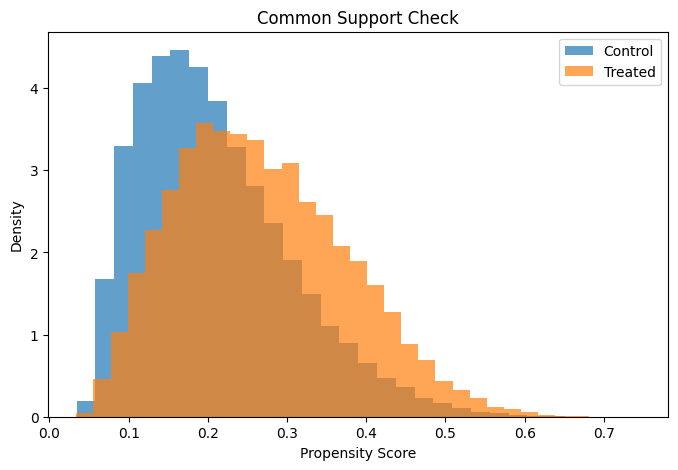

Common support: [0.034, 0.682]
DoubleML sample: 72,222 observations
DoubleML Results:
  ATE: 0.3975 (SE: 0.0143)
  95% CI: [0.3695, 0.4255]
  p-value: 0.0000
Country Comparison: High Religiosity 75
Selected countries:
  Canada: N=4,018.0, Treatment=7.9%
  Indonesia: N=3,200.0, Treatment=59.8%
  China: N=3,036.0, Treatment=0.7%
  United Kingdom: N=2,609.0, Treatment=7.2%
  United States: N=2,596.0, Treatment=20.3%
  Turkey: N=2,415.0, Treatment=20.0%
  Netherlands: N=2,145.0, Treatment=6.2%
  Hong Kong SAR: N=2,075.0, Treatment=5.5%
  Bolivia: N=2,067.0, Treatment=27.7%
  Singapore: N=2,012.0, Treatment=18.4%
  Pakistan: N=1,995.0, Treatment=39.6%
  Australia: N=1,813.0, Treatment=10.8%
  Russia: N=1,810.0, Treatment=3.1%
  Brazil: N=1,762.0, Treatment=27.1%
  Mexico: N=1,741.0, Treatment=24.5%
Using 11 confounders for religiosity

--- CANADA ---


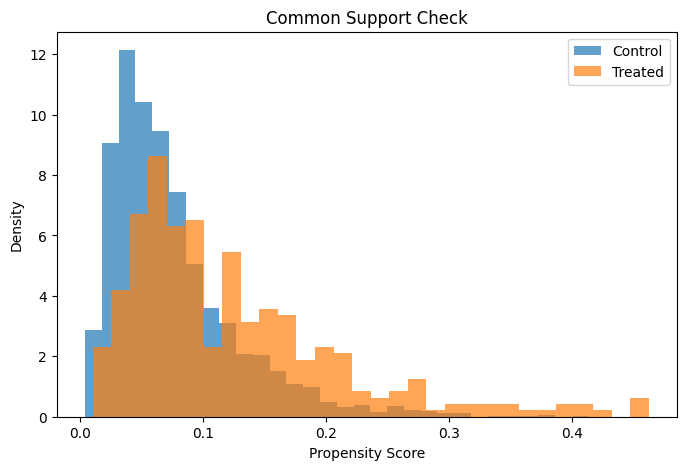

Common support: [0.010, 0.413]
DoubleML sample: 3,968 observations
DoubleML Results:
  ATE: 0.3244 (SE: 0.1167)
  95% CI: [0.0957, 0.5531]
  p-value: 0.0054

--- INDONESIA ---


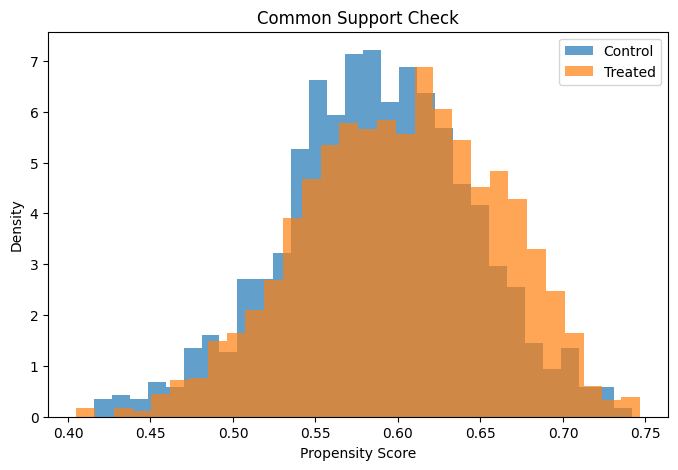

Common support: [0.416, 0.742]
DoubleML sample: 2,674 observations
DoubleML Results:
  ATE: 0.0151 (SE: 0.0545)
  95% CI: [-0.0917, 0.1219]
  p-value: 0.7821

--- CHINA ---


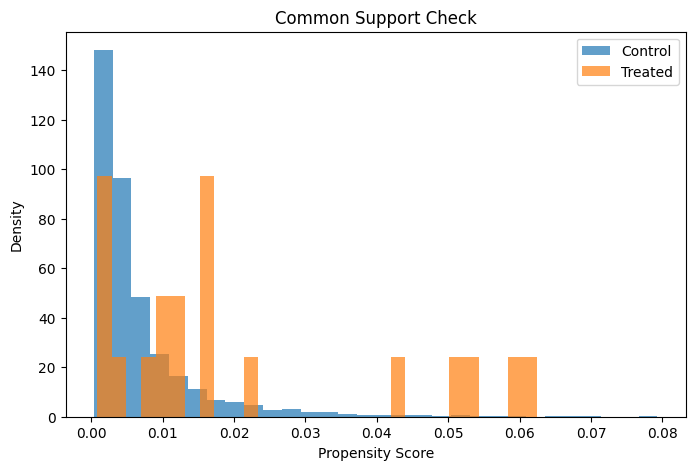

Common support: [0.001, 0.062]
Too few treated/control units after support trimming

--- UNITED KINGDOM ---


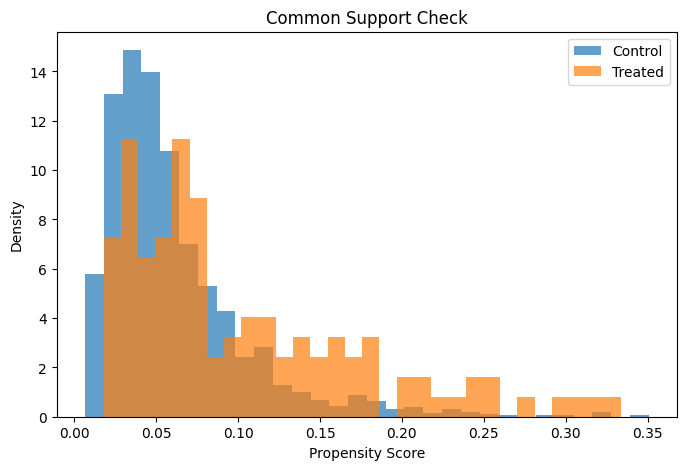

Common support: [0.018, 0.334]
DoubleML sample: 1,757 observations
Analysis failed: For the binary variable num_children, predictions obtained with the ml_g learner LinearRegression() are also observed to be binary with values 0 and 1. Make sure that for classifiers probabilities and not labels are predicted.

--- UNITED STATES ---


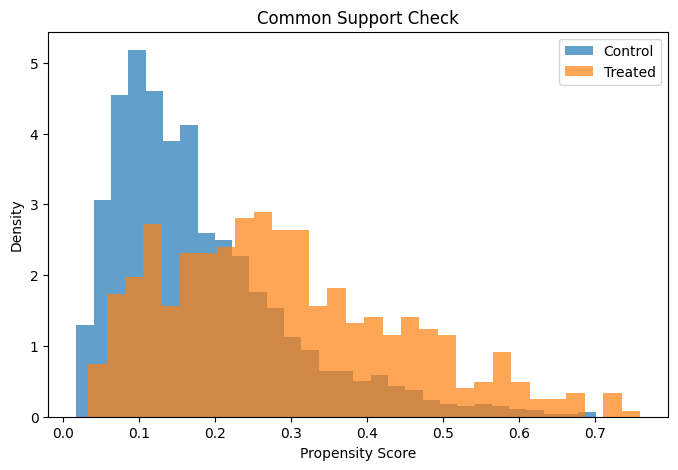

Common support: [0.033, 0.700]
DoubleML sample: 2,427 observations
DoubleML Results:
  ATE: 0.3390 (SE: 0.0849)
  95% CI: [0.1726, 0.5054]
  p-value: 0.0001

--- TURKEY ---


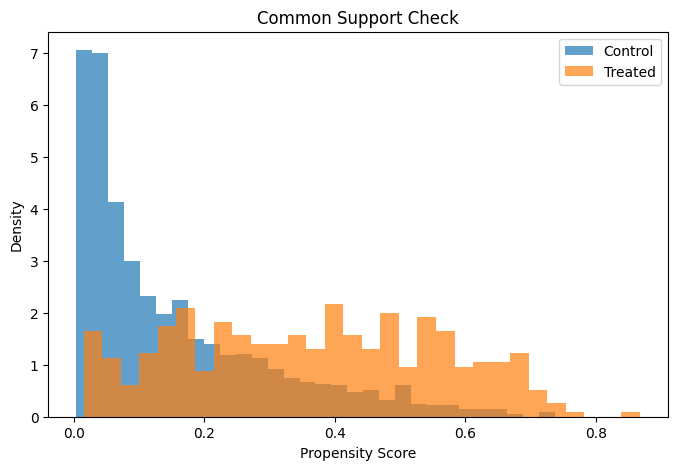

Common support: [0.015, 0.737]
DoubleML sample: 1,995 observations
DoubleML Results:
  ATE: 0.4392 (SE: 0.1912)
  95% CI: [0.0645, 0.8138]
  p-value: 0.0216

--- NETHERLANDS ---


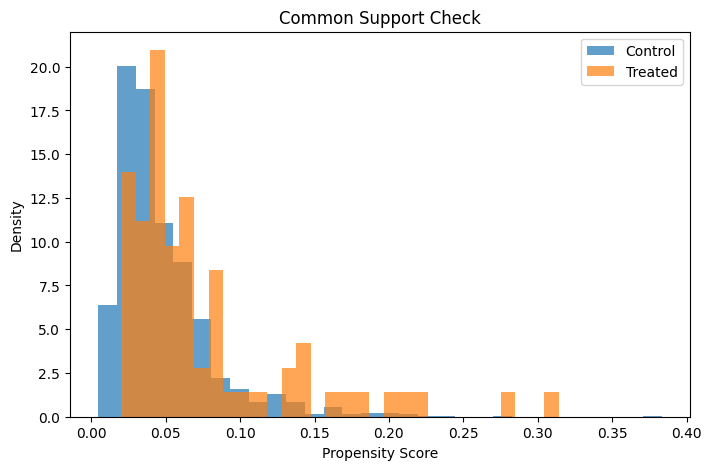

Common support: [0.020, 0.314]
DoubleML sample: 1,301 observations
DoubleML Results:
  ATE: 0.8016 (SE: 0.3668)
  95% CI: [0.0827, 1.5204]
  p-value: 0.0289

--- HONG KONG SAR ---


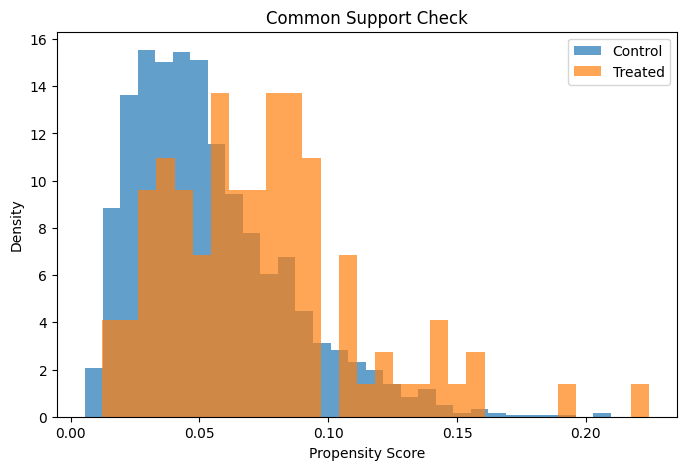

Common support: [0.012, 0.210]
DoubleML sample: 1,861 observations
DoubleML Results:
  ATE: 0.1251 (SE: 0.1737)
  95% CI: [-0.2153, 0.4655]
  p-value: 0.4714

--- BOLIVIA ---


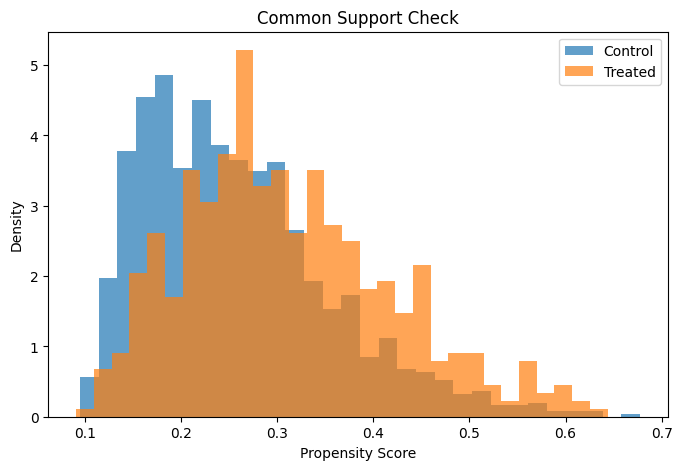

Common support: [0.095, 0.644]
DoubleML sample: 1,758 observations
DoubleML Results:
  ATE: 0.2315 (SE: 0.0811)
  95% CI: [0.0725, 0.3905]
  p-value: 0.0043

--- SINGAPORE ---


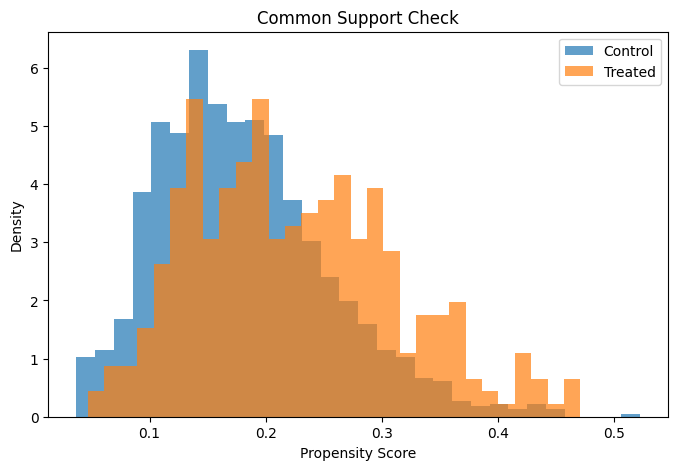

Common support: [0.047, 0.471]
DoubleML sample: 1,690 observations
DoubleML Results:
  ATE: 0.2308 (SE: 0.0834)
  95% CI: [0.0674, 0.3943]
  p-value: 0.0056

--- PAKISTAN ---


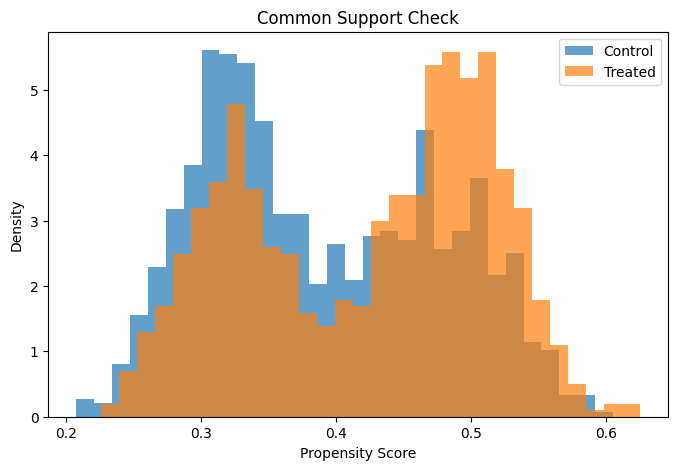

Common support: [0.226, 0.605]
DoubleML sample: 1,868 observations
DoubleML Results:
  ATE: -0.0450 (SE: 0.0763)
  95% CI: [-0.1946, 0.1045]
  p-value: 0.5552

--- AUSTRALIA ---


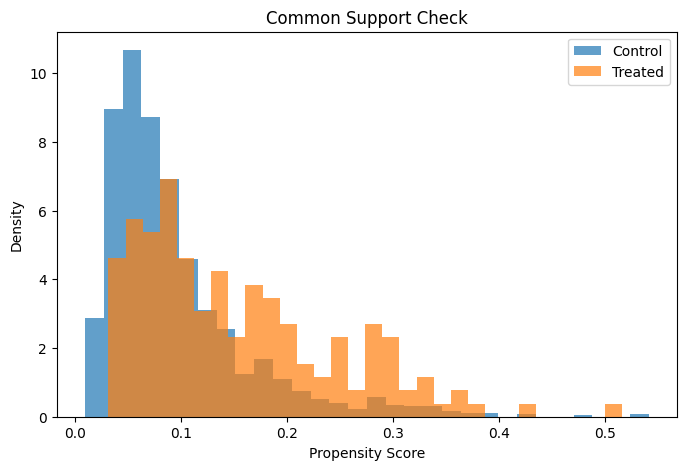

Common support: [0.032, 0.516]
DoubleML sample: 1,478 observations
DoubleML Results:
  ATE: 0.3165 (SE: 0.1989)
  95% CI: [-0.0734, 0.7064]
  p-value: 0.1116

--- RUSSIA ---


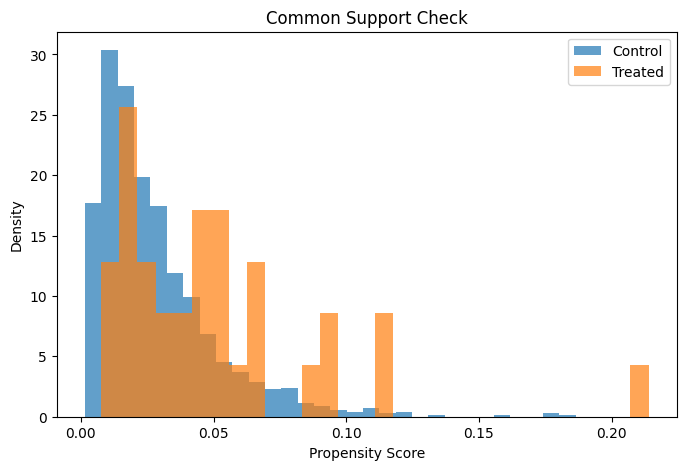

Common support: [0.008, 0.186]
Too few treated/control units after support trimming

--- BRAZIL ---


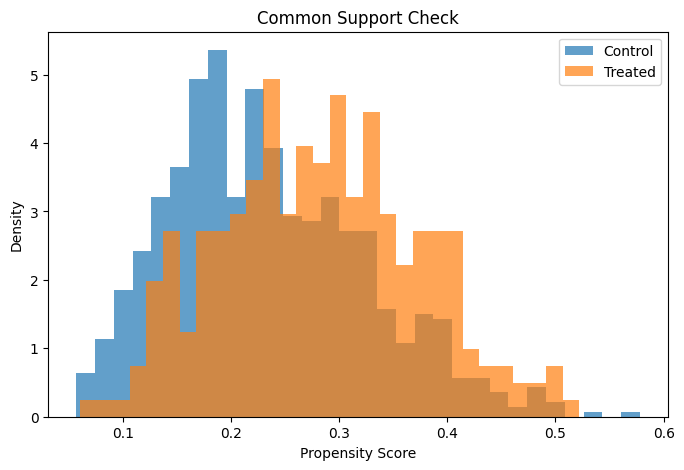

Common support: [0.060, 0.522]
DoubleML sample: 1,065 observations
DoubleML Results:
  ATE: 0.0649 (SE: 0.0958)
  95% CI: [-0.1228, 0.2526]
  p-value: 0.4978

--- MEXICO ---


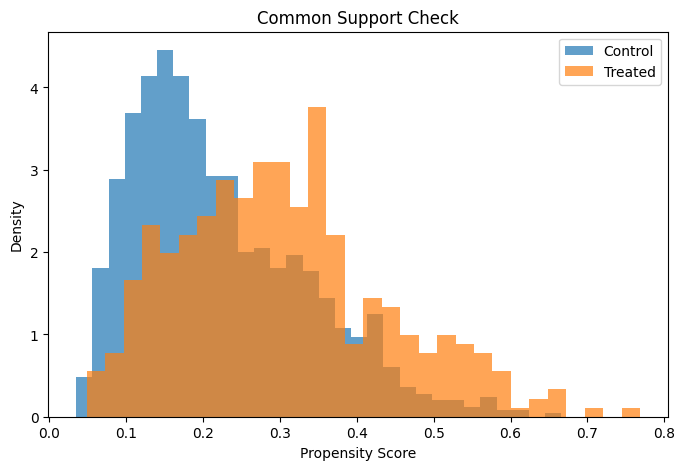

Common support: [0.049, 0.666]
DoubleML sample: 1,535 observations
DoubleML Results:
  ATE: 0.0751 (SE: 0.0978)
  95% CI: [-0.1166, 0.2668]
  p-value: 0.4426

Country Comparison Summary:
      Country    N Treatment_Rate  Effect_Size  P_Value Common_Support  Support_Width Low_Overlap Significant
       Canada 3968           7.8%        0.324    0.005      0.01–0.41          0.403         Yes         Yes
    Indonesia 2674          59.5%        0.015    0.782      0.42–0.74          0.326          No          No
United States 2449          20.3%        0.339    0.000      0.03–0.70          0.668          No         Yes
       Turkey 1995          20.1%        0.439    0.022      0.01–0.74          0.722         Yes         Yes
  Netherlands 1308           5.6%        0.802    0.029      0.02–0.31          0.294         Yes         Yes
Hong Kong SAR 1861           5.5%        0.125    0.471      0.01–0.21          0.198         Yes          No
      Bolivia 1759          27.2%        0.

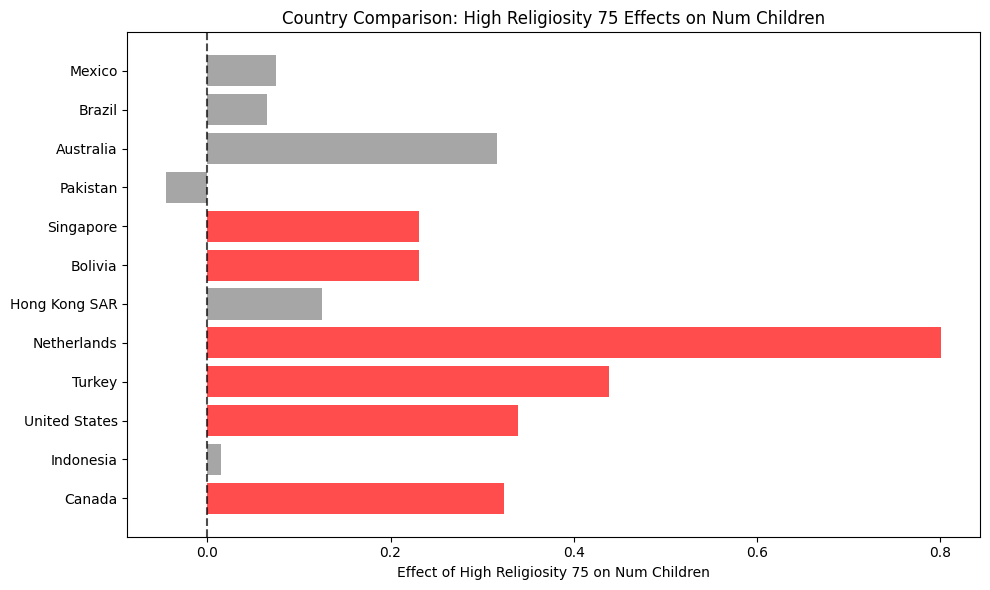

In [77]:
#relgiosity run
pooled_results = treatment_analysis(df, treatment_var='high_religiosity_75', outcome_var='num_children')
pooled_df = pooled_results['filtered_data'] 

pooled_df.to_csv("data/sensitivity_data/pooled_religion_data.csv", index=False)


#each country analysis
country_results, summary_df = country_comparison(df, treatment_var='high_religiosity_75', outcome_var='num_children')

for country_name, res in country_results.items():
    country_df = res['data']
    safe_name = country_name.replace(" ", "_").replace("/", "_")
    country_df.to_csv(f"data/sensitivity_data/countries/religion/country_religion_{safe_name}_analysis.csv", index=False)

#summary table
summary_df.to_csv("data/sensitivity_data/country_religion_analysis_summary.csv", index=False)


Fertility Analysis: Heavy Media Use
Selected 53 countries
Using 14 confounders for media analysis
Available confounders: 14

Analyzing: heavy_media_use -> num_children


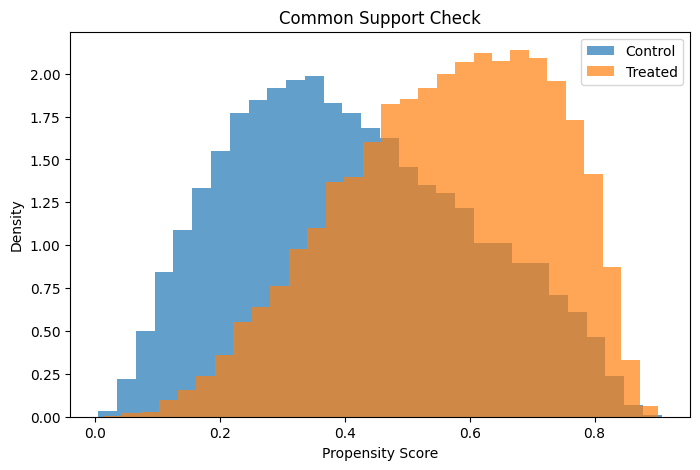

Common support: [0.013, 0.902]
DoubleML sample: 70,758 observations
DoubleML Results:
  ATE: -0.2375 (SE: 0.0127)
  95% CI: [-0.2624, -0.2126]
  p-value: 0.0000
Country Comparison: Heavy Media Use
Selected countries:
  Canada: N=4,018.0, Treatment=64.1%
  Indonesia: N=3,200.0, Treatment=35.0%
  China: N=3,036.0, Treatment=53.4%
  United Kingdom: N=2,609.0, Treatment=61.4%
  United States: N=2,596.0, Treatment=60.6%
  Turkey: N=2,415.0, Treatment=66.2%
  Netherlands: N=2,145.0, Treatment=60.7%
  Hong Kong SAR: N=2,075.0, Treatment=67.6%
  Bolivia: N=2,067.0, Treatment=33.4%
  Singapore: N=2,012.0, Treatment=63.6%
  Pakistan: N=1,995.0, Treatment=12.3%
  Australia: N=1,813.0, Treatment=43.6%
  Russia: N=1,810.0, Treatment=19.6%
  Brazil: N=1,762.0, Treatment=54.6%
  Mexico: N=1,741.0, Treatment=30.9%
Using 14 confounders for media analysis

--- CANADA ---


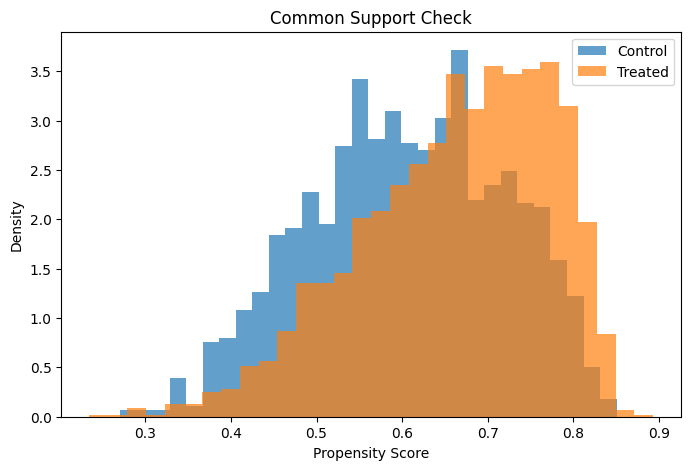

Common support: [0.270, 0.851]
DoubleML sample: 3,990 observations
DoubleML Results:
  ATE: 0.0431 (SE: 0.0376)
  95% CI: [-0.0306, 0.1168]
  p-value: 0.2516

--- INDONESIA ---


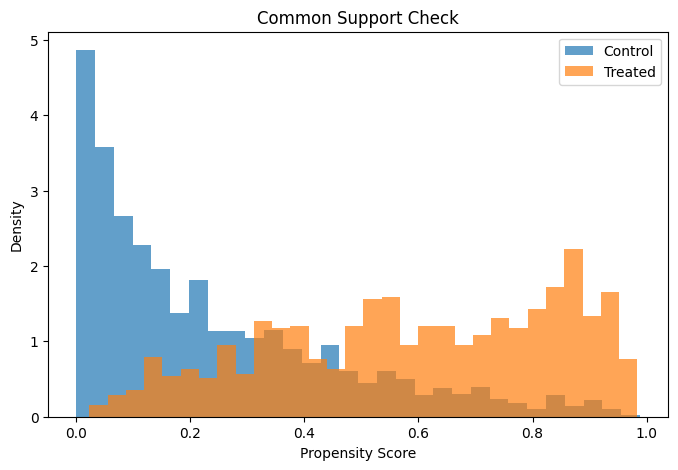

Common support: [0.024, 0.983]
DoubleML sample: 2,468 observations
DoubleML Results:
  ATE: -0.0542 (SE: 0.1077)
  95% CI: [-0.2652, 0.1568]
  p-value: 0.6145

--- CHINA ---


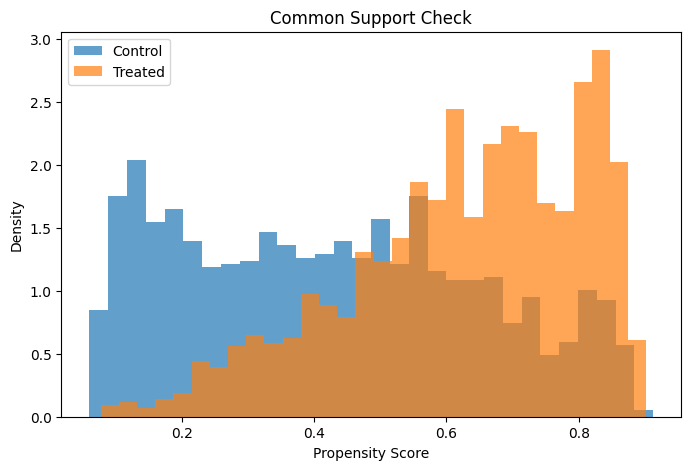

Common support: [0.077, 0.902]
DoubleML sample: 2,880 observations
DoubleML Results:
  ATE: -0.1039 (SE: 0.0344)
  95% CI: [-0.1714, -0.0365]
  p-value: 0.0025

--- UNITED KINGDOM ---


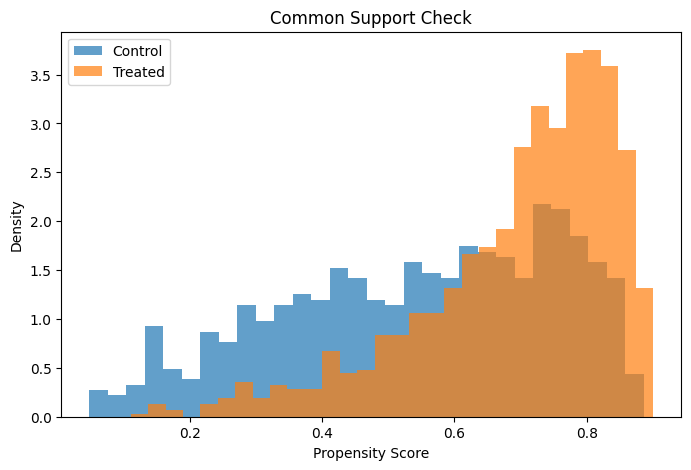

Common support: [0.111, 0.886]
DoubleML sample: 1,815 observations
Analysis failed: For the binary variable num_children, predictions obtained with the ml_g learner LinearRegression() are also observed to be binary with values 0 and 1. Make sure that for classifiers probabilities and not labels are predicted.

--- UNITED STATES ---


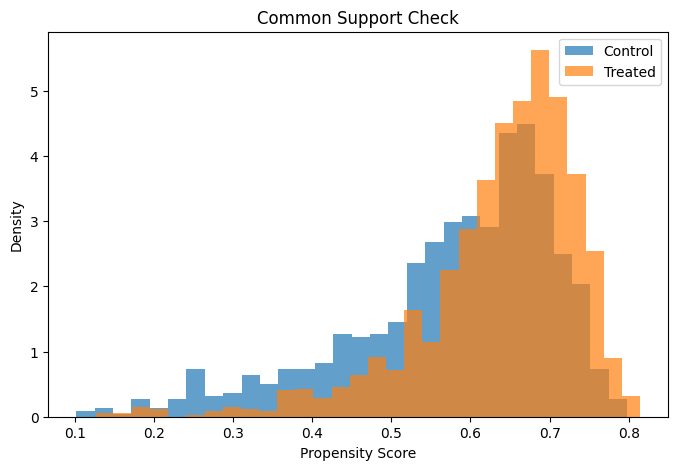

Common support: [0.126, 0.798]
DoubleML sample: 2,433 observations
DoubleML Results:
  ATE: 0.1184 (SE: 0.0609)
  95% CI: [-0.0011, 0.2378]
  p-value: 0.0521

--- TURKEY ---


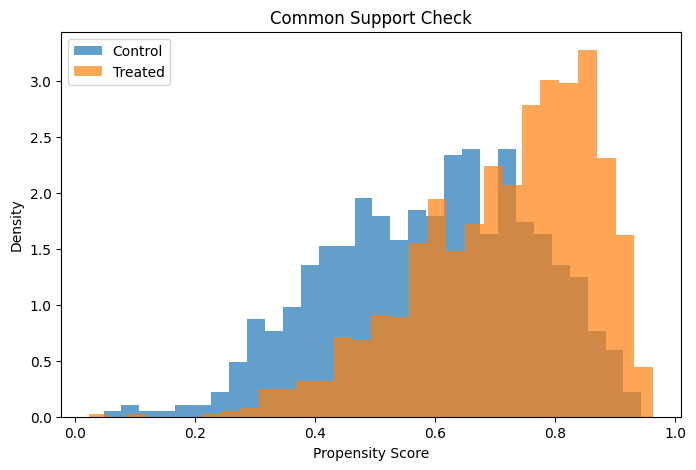

Common support: [0.048, 0.944]
DoubleML sample: 1,907 observations
DoubleML Results:
  ATE: -0.1777 (SE: 0.0548)
  95% CI: [-0.2850, -0.0703]
  p-value: 0.0012

--- NETHERLANDS ---


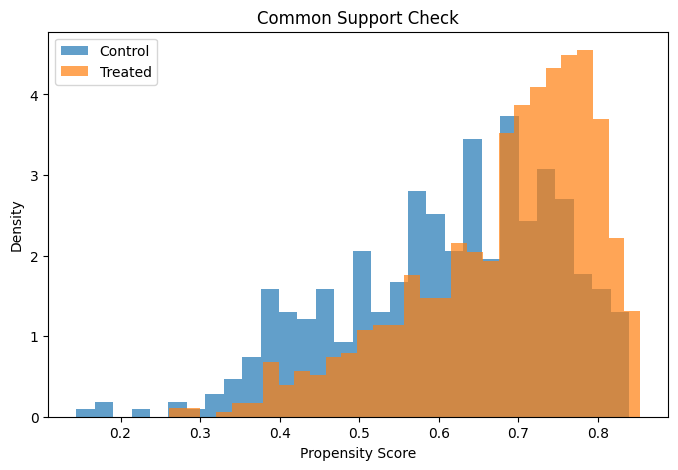

Common support: [0.261, 0.839]
DoubleML sample: 1,330 observations
DoubleML Results:
  ATE: 0.0002 (SE: 0.0724)
  95% CI: [-0.1418, 0.1422]
  p-value: 0.9979

--- HONG KONG SAR ---


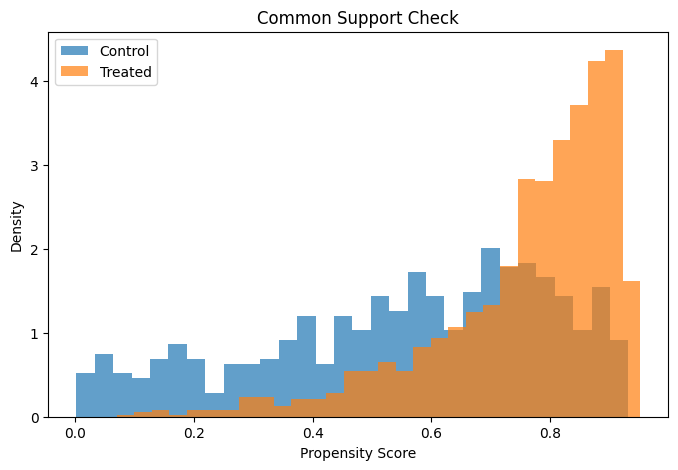

Common support: [0.070, 0.932]
DoubleML sample: 1,828 observations
DoubleML Results:
  ATE: -0.0759 (SE: 0.0531)
  95% CI: [-0.1800, 0.0282]
  p-value: 0.1528

--- BOLIVIA ---


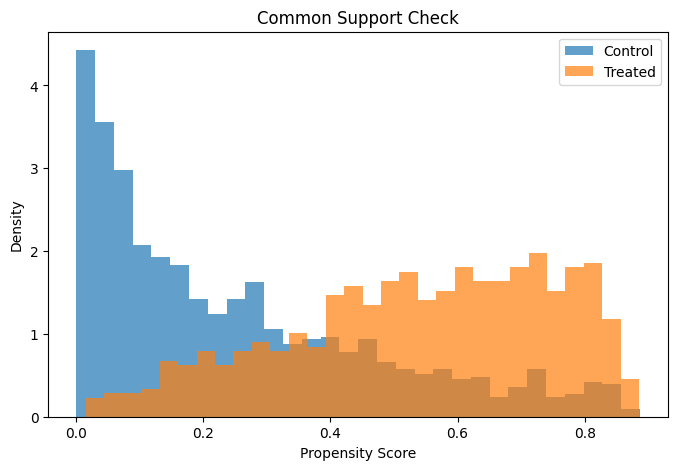

Common support: [0.016, 0.885]
DoubleML sample: 1,655 observations
DoubleML Results:
  ATE: -0.1247 (SE: 0.1400)
  95% CI: [-0.3990, 0.1496]
  p-value: 0.3728

--- SINGAPORE ---


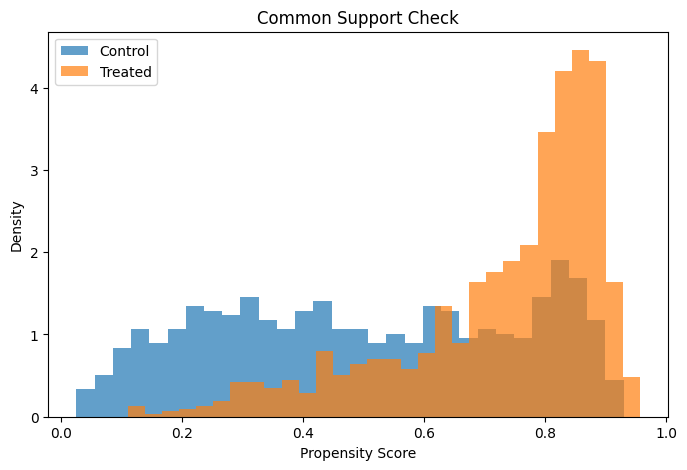

Common support: [0.110, 0.929]
DoubleML sample: 1,644 observations
DoubleML Results:
  ATE: 0.0712 (SE: 0.0620)
  95% CI: [-0.0502, 0.1926]
  p-value: 0.2505

--- PAKISTAN ---


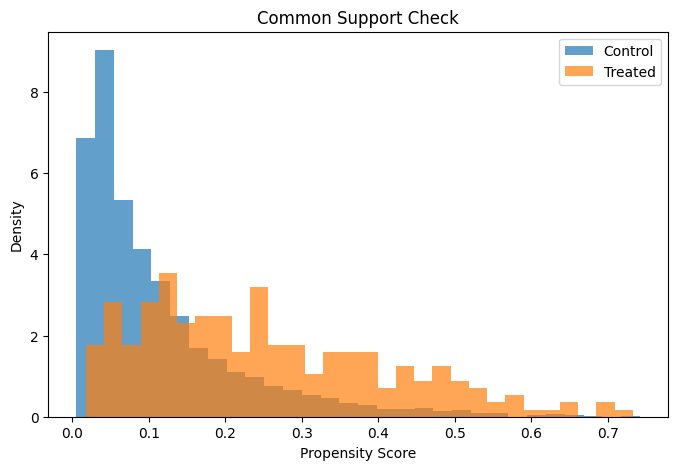

Common support: [0.018, 0.733]
DoubleML sample: 1,740 observations
DoubleML Results:
  ATE: -0.3777 (SE: 0.1737)
  95% CI: [-0.7181, -0.0372]
  p-value: 0.0297

--- AUSTRALIA ---


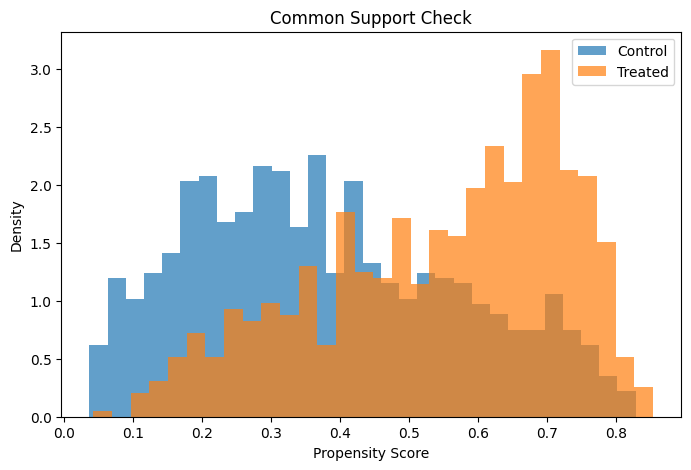

Common support: [0.043, 0.828]
DoubleML sample: 1,546 observations
DoubleML Results:
  ATE: 0.1824 (SE: 0.1187)
  95% CI: [-0.0502, 0.4150]
  p-value: 0.1243

--- RUSSIA ---


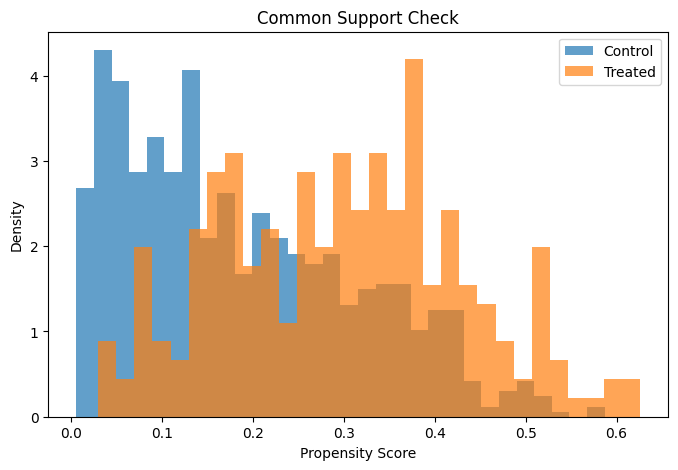

Common support: [0.030, 0.587]
DoubleML sample: 1,028 observations
DoubleML Results:
  ATE: -0.0043 (SE: 0.1221)
  95% CI: [-0.2436, 0.2351]
  p-value: 0.9721

--- BRAZIL ---


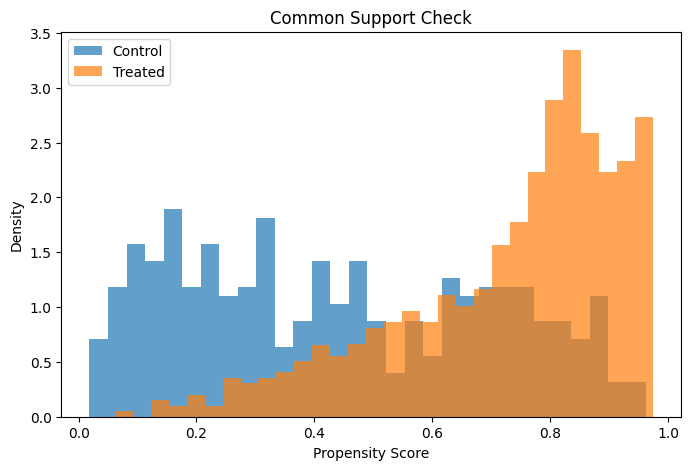

Common support: [0.062, 0.962]
DoubleML sample: 1,019 observations
DoubleML Results:
  ATE: 0.0087 (SE: 0.0924)
  95% CI: [-0.1724, 0.1898]
  p-value: 0.9248

--- MEXICO ---


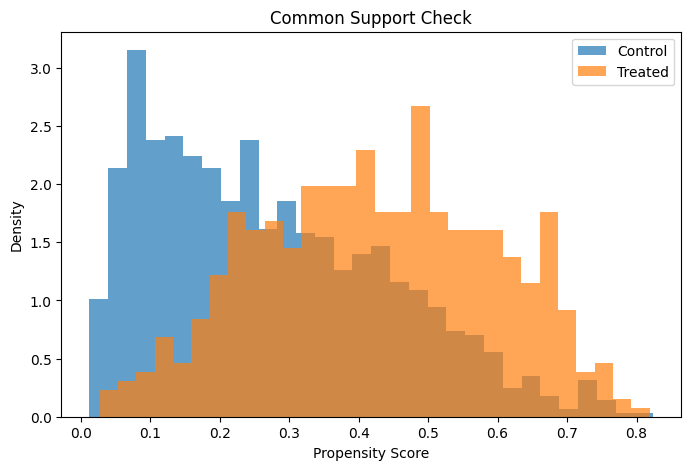

Common support: [0.027, 0.819]
DoubleML sample: 1,525 observations
DoubleML Results:
  ATE: -0.0848 (SE: 0.1277)
  95% CI: [-0.3350, 0.1655]
  p-value: 0.5067

Country Comparison Summary:
      Country    N Treatment_Rate  Effect_Size  P_Value Common_Support  Support_Width Low_Overlap Significant
       Canada 3990          64.1%        0.043    0.252      0.27–0.85          0.580          No          No
    Indonesia 2468          39.8%       -0.054    0.615      0.02–0.98          0.960         Yes          No
        China 2912          53.6%       -0.104    0.003      0.08–0.90          0.825          No         Yes
United States 2456          61.4%        0.118    0.052      0.13–0.80          0.671          No          No
       Turkey 1907          67.7%       -0.178    0.001      0.05–0.94          0.896          No         Yes
  Netherlands 1337          65.7%        0.000    0.998      0.26–0.84          0.579          No          No
Hong Kong SAR 1828          70.6%       -0

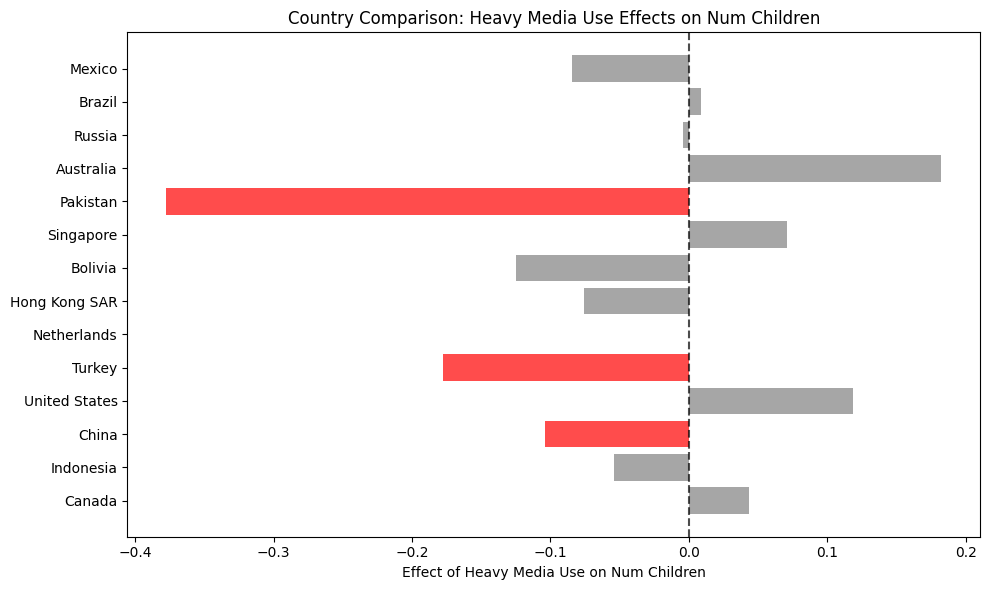

In [81]:
#media run
pooled_results = treatment_analysis(df, treatment_var='heavy_media_use', outcome_var='num_children')
pooled_df = pooled_results['filtered_data'] 

pooled_df.to_csv("data/sensitivity_data/pooled_media_data.csv", index=False)

#each country analysis
country_results, summary_df = country_comparison(df, treatment_var='heavy_media_use', outcome_var='num_children')

for country_name, res in country_results.items():
    country_df = res['data']
    safe_name = country_name.replace(" ", "_").replace("/", "_")
    country_df.to_csv(f"data/sensitivity_data/countries/media/country_media_{safe_name}_analysis.csv", index=False)

#summary table
summary_df.to_csv("data/sensitivity_data/country_media_analysis_summary.csv", index=False)

Fertility Analysis: High Traditional Gender


Selected 53 countries
Using 13 clean confounders for gender analysis
Available confounders: 13

Analyzing: high_traditional_gender -> num_children


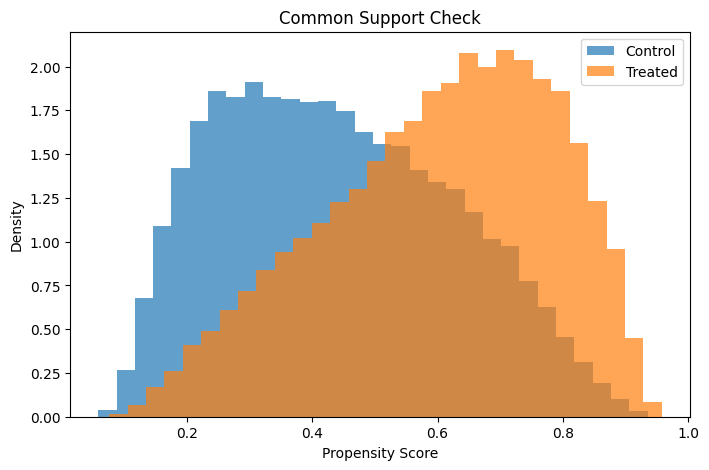

Common support: [0.075, 0.935]
DoubleML sample: 71,213 observations
DoubleML Results:
  ATE: 0.1352 (SE: 0.0118)
  95% CI: [0.1119, 0.1584]
  p-value: 0.0000
Country Comparison: High Traditional Gender
Selected countries:
  Canada: N=4,018.0, Treatment=15.4%
  Indonesia: N=3,200.0, Treatment=81.5%
  China: N=3,036.0, Treatment=60.7%
  United Kingdom: N=2,609.0, Treatment=11.0%
  United States: N=2,596.0, Treatment=17.9%
  Turkey: N=2,415.0, Treatment=63.9%
  Netherlands: N=2,145.0, Treatment=8.2%
  Hong Kong SAR: N=2,075.0, Treatment=44.6%
  Bolivia: N=2,067.0, Treatment=56.9%
  Singapore: N=2,012.0, Treatment=38.9%
  Pakistan: N=1,995.0, Treatment=89.3%
  Australia: N=1,813.0, Treatment=15.6%
  Russia: N=1,810.0, Treatment=60.8%
  Brazil: N=1,762.0, Treatment=32.2%
  Mexico: N=1,741.0, Treatment=38.8%
Using 13 clean confounders for gender analysis

--- CANADA ---


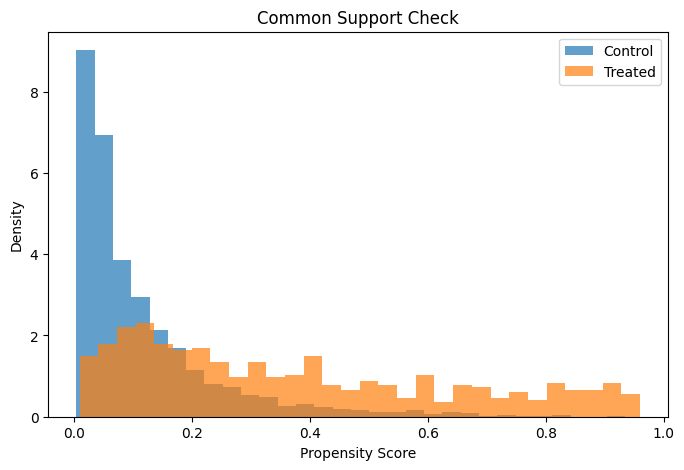

Common support: [0.010, 0.935]
DoubleML sample: 3,884 observations
DoubleML Results:
  ATE: 0.0476 (SE: 0.0808)
  95% CI: [-0.1108, 0.2059]
  p-value: 0.5562

--- INDONESIA ---


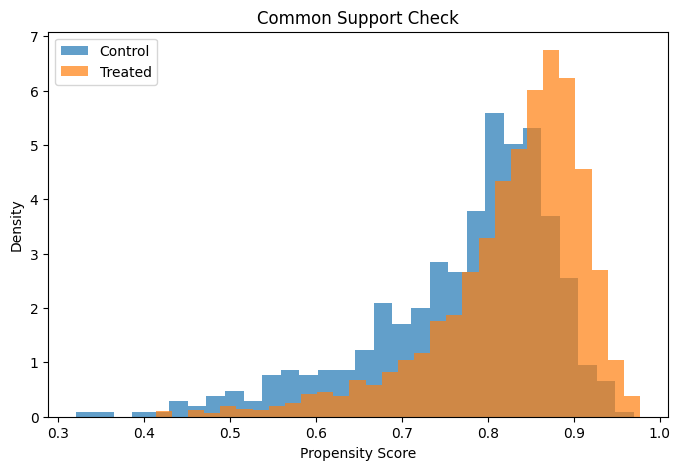

Common support: [0.414, 0.970]
DoubleML sample: 2,669 observations
DoubleML Results:
  ATE: -0.0772 (SE: 0.0962)
  95% CI: [-0.2657, 0.1114]
  p-value: 0.4226

--- CHINA ---


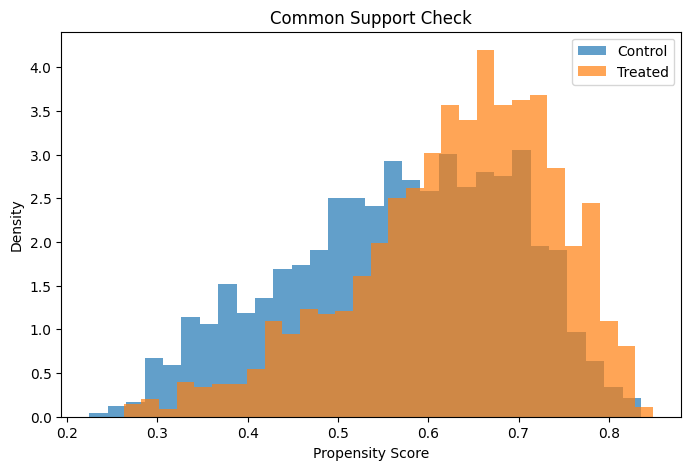

Common support: [0.263, 0.836]
DoubleML sample: 2,900 observations
DoubleML Results:
  ATE: 0.0455 (SE: 0.0293)
  95% CI: [-0.0119, 0.1029]
  p-value: 0.1206

--- UNITED KINGDOM ---


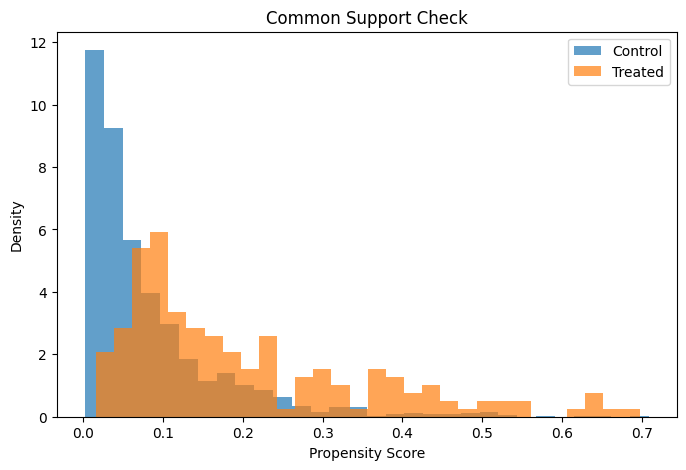

Common support: [0.016, 0.698]
DoubleML sample: 1,596 observations
Analysis failed: For the binary variable num_children, predictions obtained with the ml_g learner LinearRegression() are also observed to be binary with values 0 and 1. Make sure that for classifiers probabilities and not labels are predicted.

--- UNITED STATES ---


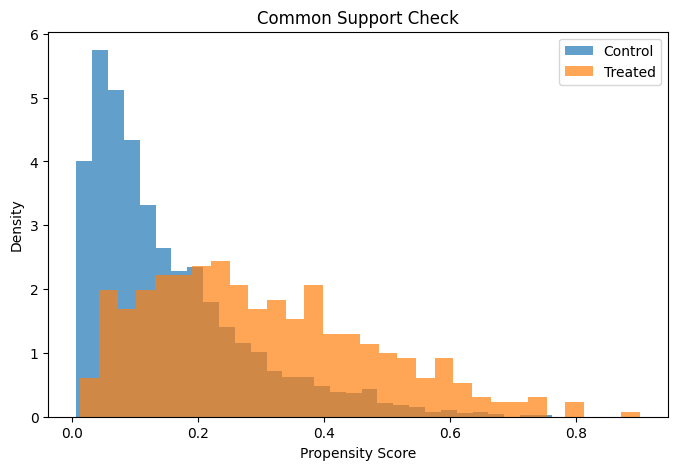

Common support: [0.014, 0.762]
DoubleML sample: 2,434 observations
DoubleML Results:
  ATE: 0.1952 (SE: 0.1006)
  95% CI: [-0.0021, 0.3924]
  p-value: 0.0525

--- TURKEY ---


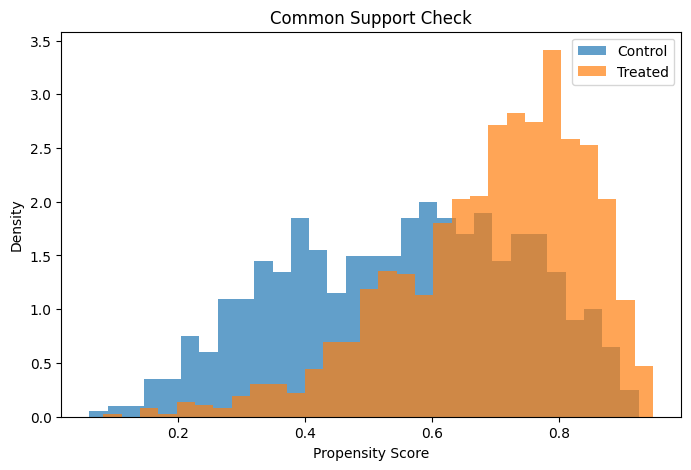

Common support: [0.082, 0.926]
DoubleML sample: 1,928 observations
DoubleML Results:
  ATE: 0.0670 (SE: 0.0602)
  95% CI: [-0.0509, 0.1850]
  p-value: 0.2651

--- NETHERLANDS ---


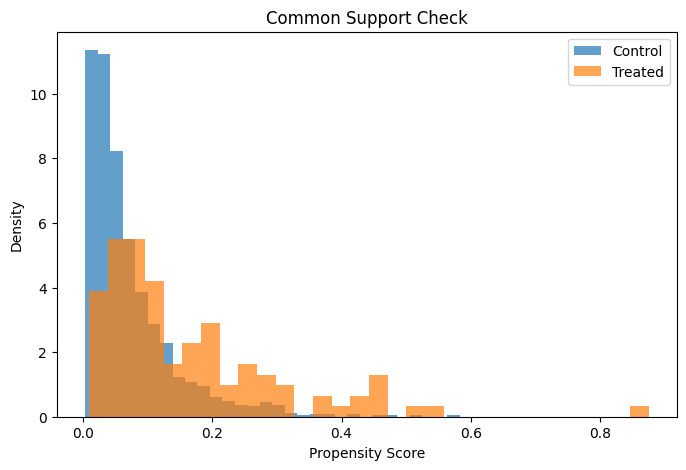

Common support: [0.010, 0.583]
DoubleML sample: 1,313 observations
DoubleML Results:
  ATE: 0.0044 (SE: 0.1805)
  95% CI: [-0.3494, 0.3581]
  p-value: 0.9808

--- HONG KONG SAR ---


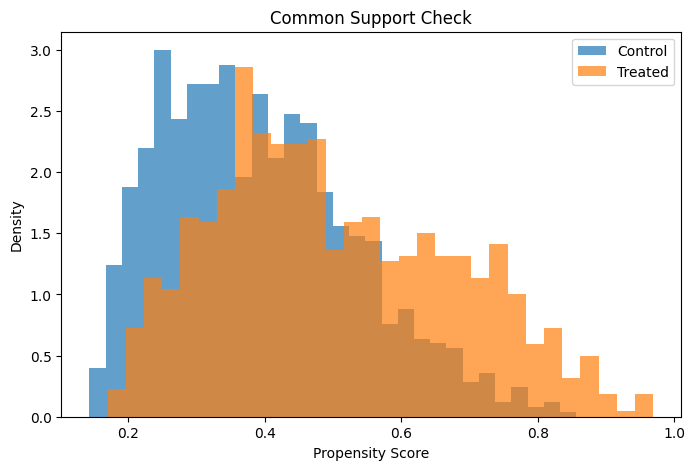

Common support: [0.170, 0.856]
DoubleML sample: 1,840 observations
DoubleML Results:
  ATE: 0.1503 (SE: 0.0428)
  95% CI: [0.0664, 0.2342]
  p-value: 0.0004

--- BOLIVIA ---


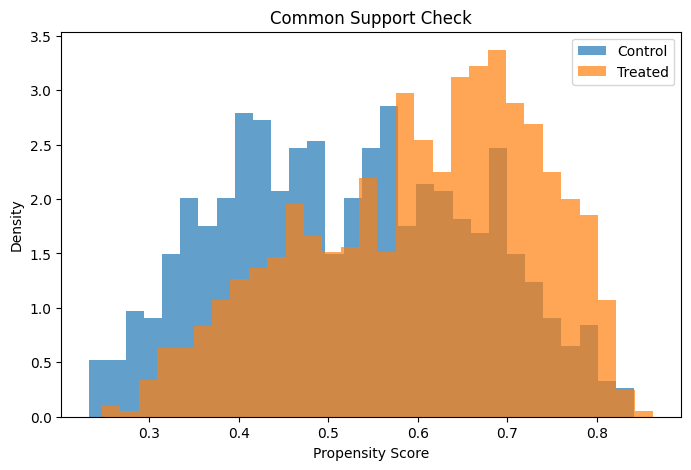

Common support: [0.247, 0.842]
DoubleML sample: 1,750 observations
DoubleML Results:
  ATE: -0.0083 (SE: 0.0723)
  95% CI: [-0.1501, 0.1334]
  p-value: 0.9085

--- SINGAPORE ---


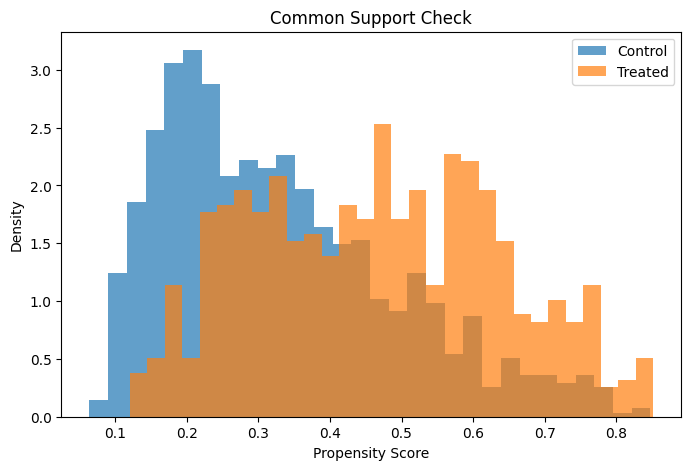

Common support: [0.120, 0.848]
DoubleML sample: 1,641 observations
DoubleML Results:
  ATE: 0.1092 (SE: 0.0591)
  95% CI: [-0.0065, 0.2250]
  p-value: 0.0644

--- PAKISTAN ---


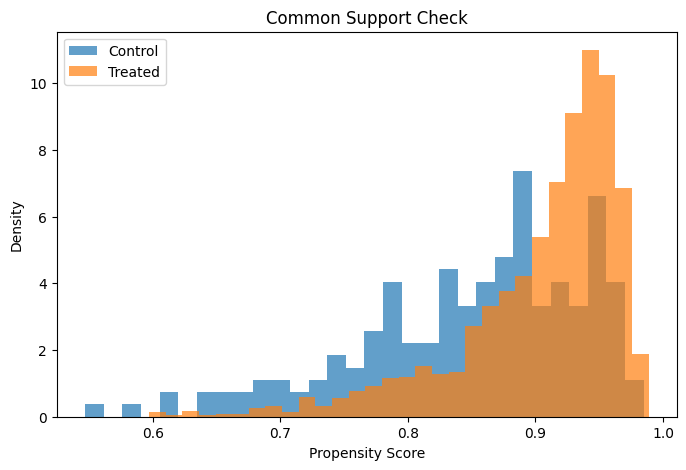

Common support: [0.597, 0.985]
DoubleML sample: 1,845 observations
DoubleML Results:
  ATE: -0.0015 (SE: 0.1796)
  95% CI: [-0.3536, 0.3506]
  p-value: 0.9933

--- AUSTRALIA ---


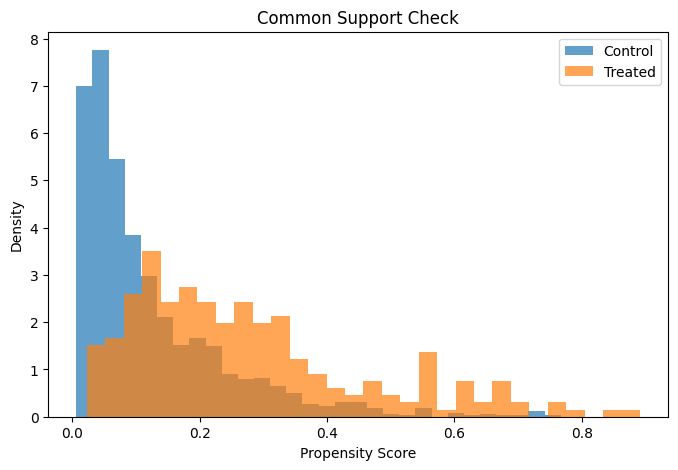

Common support: [0.023, 0.767]
DoubleML sample: 1,418 observations
DoubleML Results:
  ATE: -0.1993 (SE: 0.1017)
  95% CI: [-0.3985, -0.0000]
  p-value: 0.0500

--- RUSSIA ---


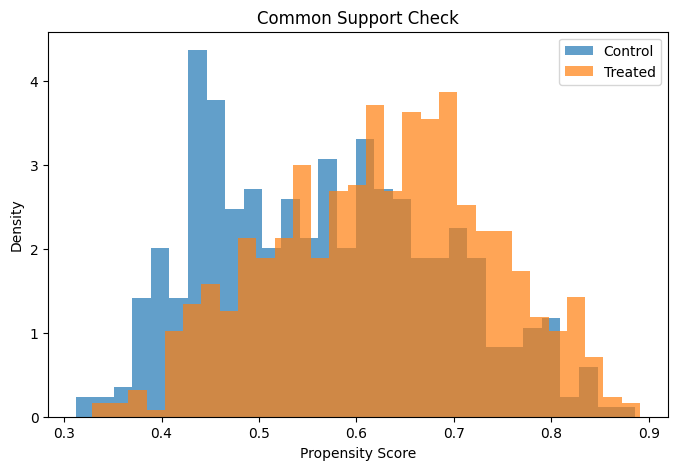

Common support: [0.328, 0.886]
DoubleML sample: 1,115 observations
DoubleML Results:
  ATE: 0.0532 (SE: 0.0722)
  95% CI: [-0.0882, 0.1946]
  p-value: 0.4608

--- BRAZIL ---


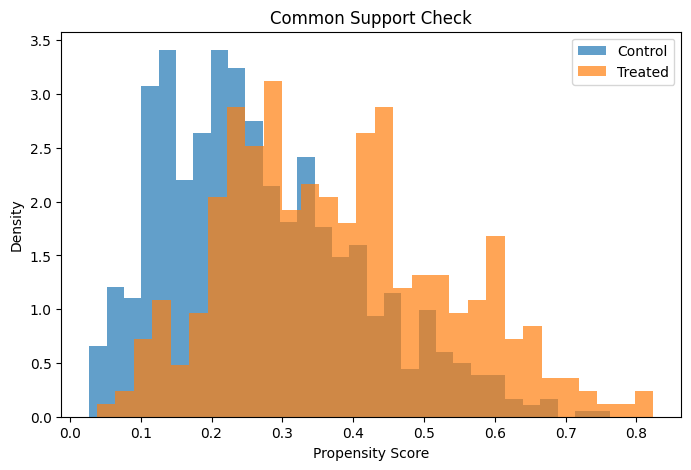

Common support: [0.038, 0.762]
DoubleML sample: 1,055 observations
DoubleML Results:
  ATE: 0.0495 (SE: 0.0977)
  95% CI: [-0.1419, 0.2409]
  p-value: 0.6123

--- MEXICO ---


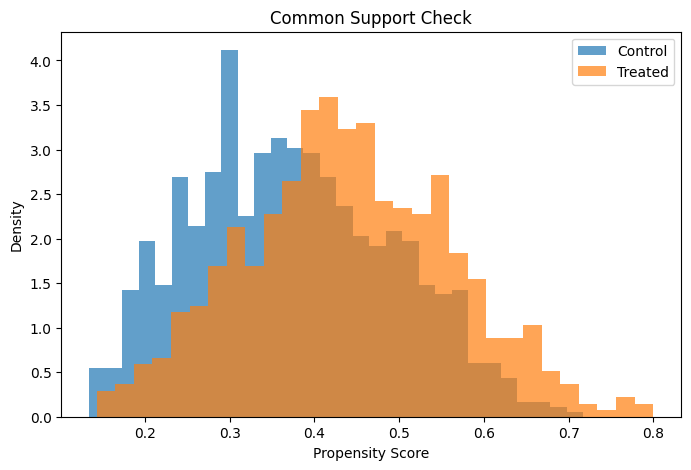

Common support: [0.143, 0.717]
DoubleML sample: 1,529 observations
DoubleML Results:
  ATE: 0.0118 (SE: 0.0816)
  95% CI: [-0.1481, 0.1718]
  p-value: 0.8849

Country Comparison Summary:
      Country    N Treatment_Rate  Effect_Size  P_Value Common_Support  Support_Width Low_Overlap Significant
       Canada 3884          15.6%        0.048    0.556      0.01–0.93          0.925         Yes          No
    Indonesia 2669          81.9%       -0.077    0.423      0.41–0.97          0.556         Yes          No
        China 2932          60.6%        0.045    0.121      0.26–0.84          0.573          No          No
United States 2457          17.8%        0.195    0.052      0.01–0.76          0.748         Yes          No
       Turkey 1928          64.1%        0.067    0.265      0.08–0.93          0.844          No          No
  Netherlands 1321           8.0%        0.004    0.981      0.01–0.58          0.573         Yes          No
Hong Kong SAR 1840          43.6%        0.

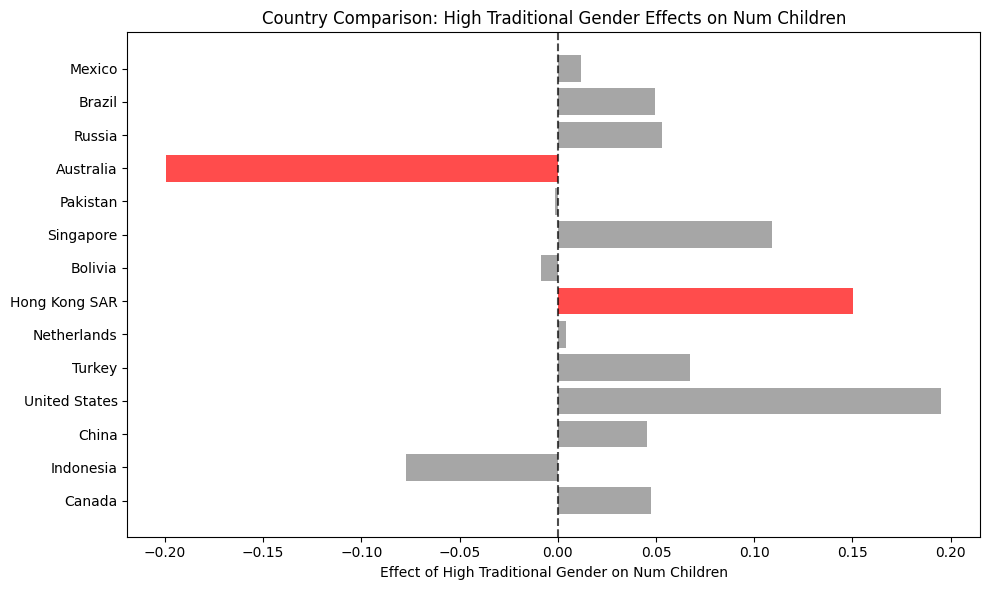

In [79]:
#gender run
pooled_results = treatment_analysis(df, treatment_var='high_traditional_gender', outcome_var='num_children')
pooled_df = pooled_results['filtered_data'] 

pooled_df.to_csv("data/sensitivity_data/pooled_gender_data.csv", index=False)


#each country analysis
country_results, summary_df = country_comparison(df, treatment_var='high_traditional_gender', outcome_var='num_children')

for country_name, res in country_results.items():
    country_df = res['data']
    safe_name = country_name.replace(" ", "_").replace("/", "_")
    country_df.to_csv(f"data/sensitivity_data/countries/gender/country_gender_{safe_name}_analysis.csv", index=False)

#summary table
summary_df.to_csv("data/sensitivity_data/country_gender_analysis_summary.csv", index=False)

Fertility Analysis: High Well Being
Selected 53 countries
Using 15 confounders for well-being analysis
Available confounders: 15

Analyzing: high_well_being -> num_children


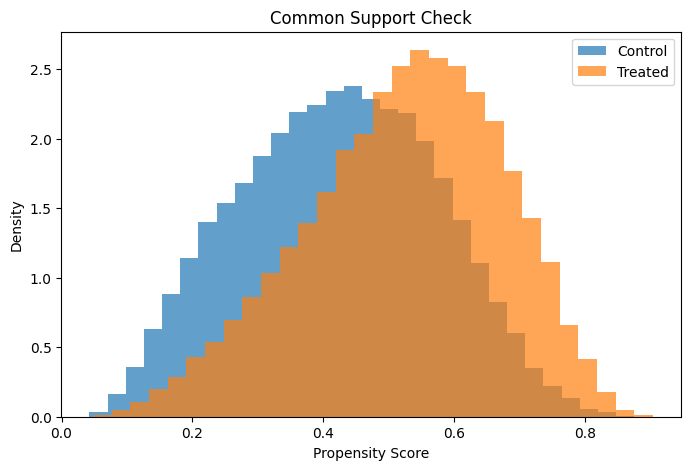

Common support: [0.048, 0.875]
DoubleML sample: 70,752 observations
DoubleML Results:
  ATE: 0.0573 (SE: 0.0113)
  95% CI: [0.0351, 0.0795]
  p-value: 0.0000
Country Comparison: High Well Being
Selected countries:
  Canada: N=4,018.0, Treatment=52.0%
  Indonesia: N=3,200.0, Treatment=57.9%
  China: N=3,036.0, Treatment=52.1%
  United Kingdom: N=2,609.0, Treatment=55.7%
  United States: N=2,596.0, Treatment=52.2%
  Turkey: N=2,415.0, Treatment=34.7%
  Netherlands: N=2,145.0, Treatment=58.4%
  Hong Kong SAR: N=2,075.0, Treatment=36.6%
  Bolivia: N=2,067.0, Treatment=52.4%
  Singapore: N=2,012.0, Treatment=44.7%
  Pakistan: N=1,995.0, Treatment=61.3%
  Australia: N=1,813.0, Treatment=62.9%
  Russia: N=1,810.0, Treatment=30.8%
  Brazil: N=1,762.0, Treatment=50.6%
  Mexico: N=1,741.0, Treatment=68.9%
Using 15 confounders for well-being analysis

--- CANADA ---


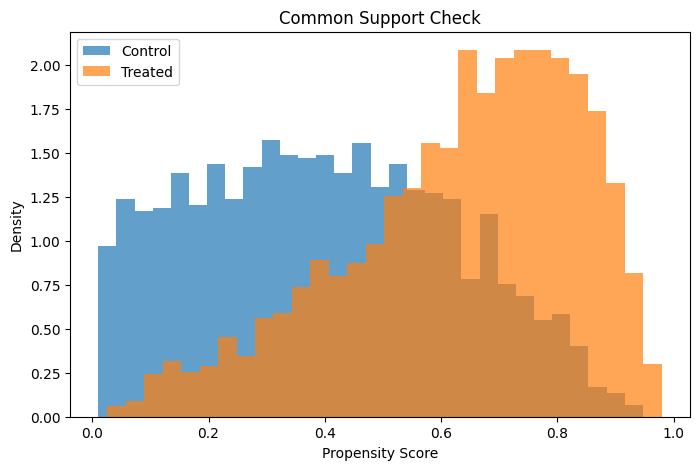

Common support: [0.025, 0.947]
DoubleML sample: 3,956 observations
DoubleML Results:
  ATE: -0.0023 (SE: 0.0465)
  95% CI: [-0.0936, 0.0889]
  p-value: 0.9598

--- INDONESIA ---


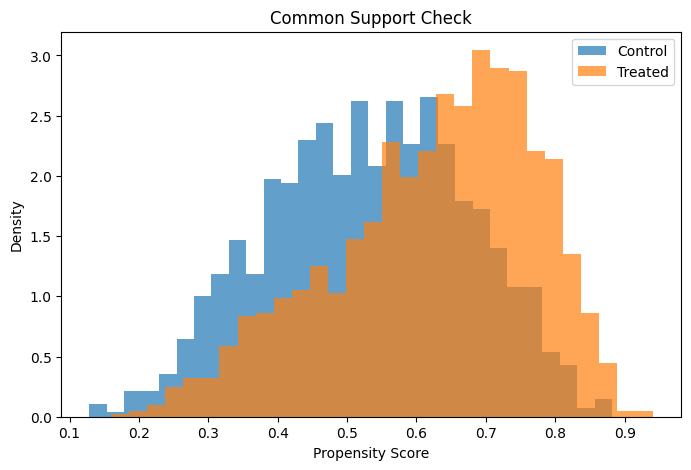

Common support: [0.160, 0.882]
DoubleML sample: 2,665 observations
DoubleML Results:
  ATE: 0.0544 (SE: 0.0572)
  95% CI: [-0.0578, 0.1666]
  p-value: 0.3419

--- CHINA ---


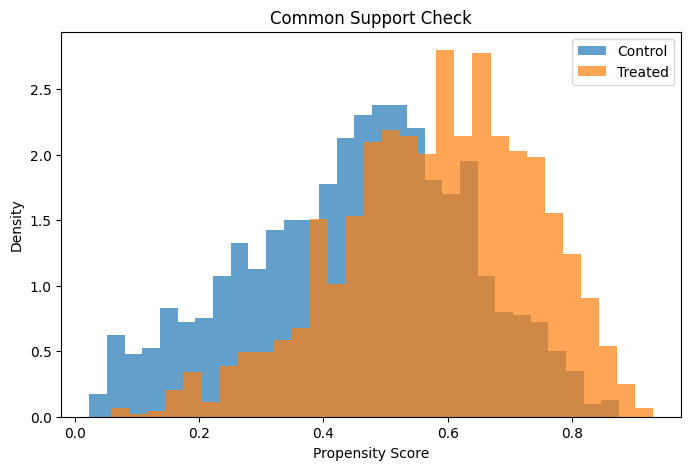

Common support: [0.058, 0.876]
DoubleML sample: 2,868 observations
DoubleML Results:
  ATE: 0.0164 (SE: 0.0290)
  95% CI: [-0.0404, 0.0732]
  p-value: 0.5719

--- UNITED KINGDOM ---


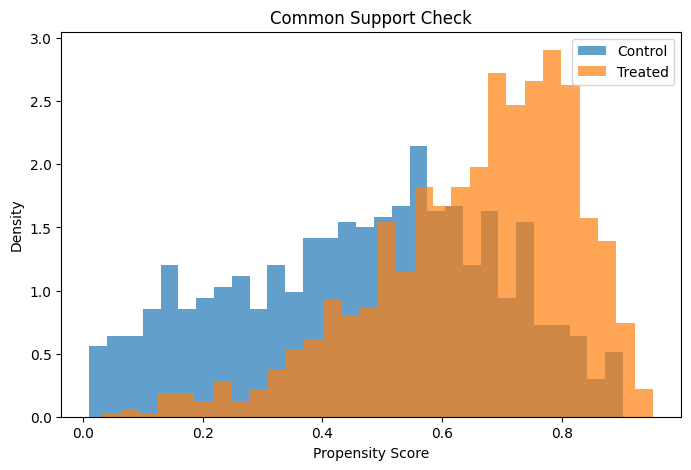

Common support: [0.033, 0.902]
DoubleML sample: 1,814 observations
Analysis failed: For the binary variable num_children, predictions obtained with the ml_g learner LinearRegression() are also observed to be binary with values 0 and 1. Make sure that for classifiers probabilities and not labels are predicted.

--- UNITED STATES ---


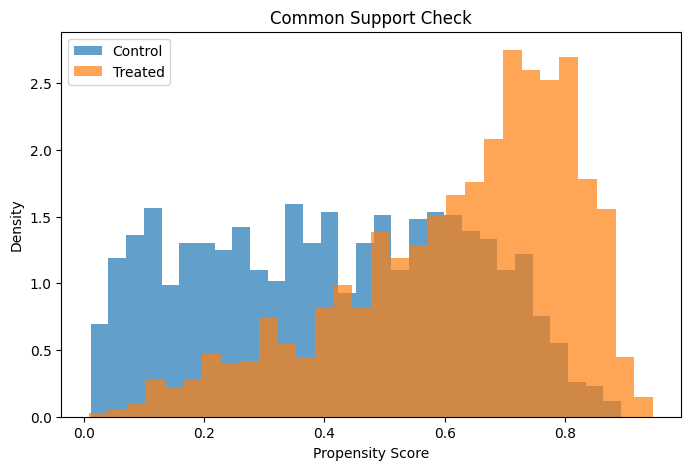

Common support: [0.011, 0.894]
DoubleML sample: 2,420 observations
DoubleML Results:
  ATE: 0.0765 (SE: 0.0648)
  95% CI: [-0.0506, 0.2035]
  p-value: 0.2381

--- TURKEY ---


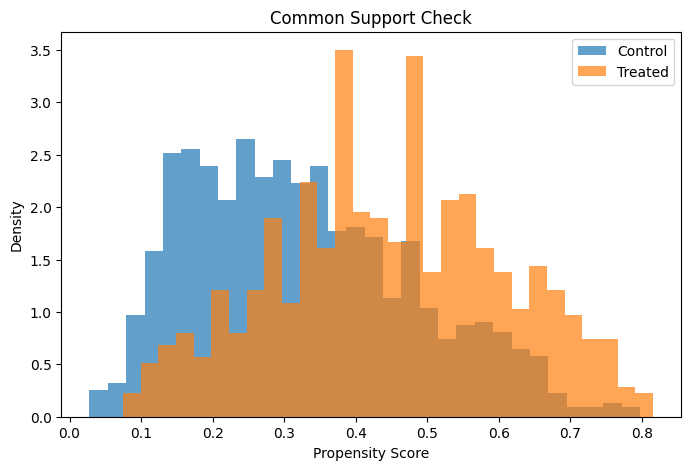

Common support: [0.075, 0.797]
DoubleML sample: 1,894 observations
DoubleML Results:
  ATE: -0.2118 (SE: 0.0556)
  95% CI: [-0.3208, -0.1027]
  p-value: 0.0001

--- NETHERLANDS ---


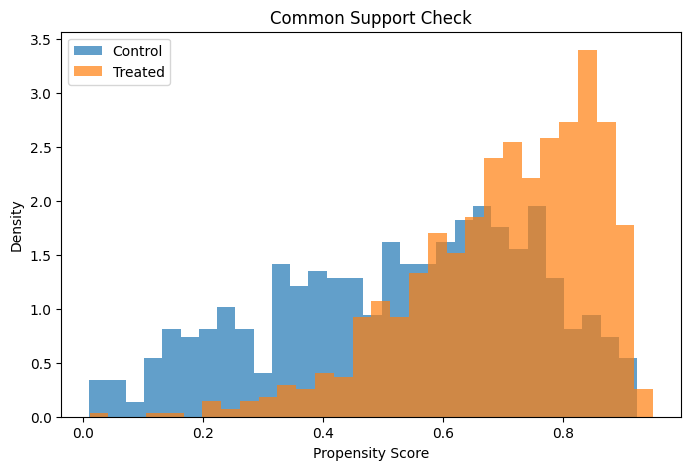

Common support: [0.012, 0.924]
DoubleML sample: 1,339 observations
DoubleML Results:
  ATE: -0.1261 (SE: 0.1113)
  95% CI: [-0.3442, 0.0921]
  p-value: 0.2573

--- HONG KONG SAR ---


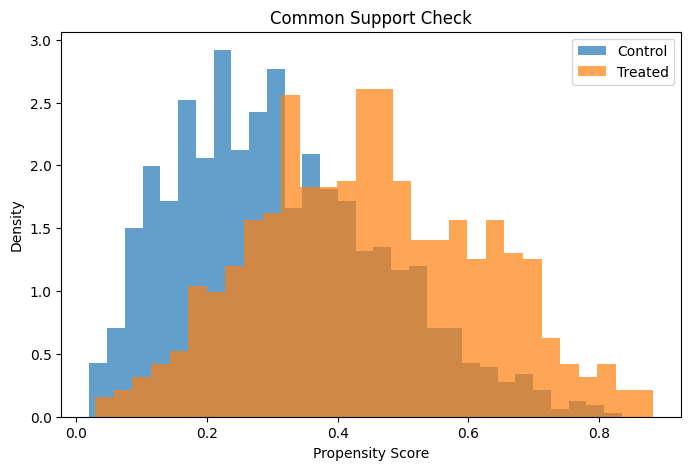

Common support: [0.030, 0.835]
DoubleML sample: 1,862 observations
DoubleML Results:
  ATE: 0.0845 (SE: 0.0666)
  95% CI: [-0.0461, 0.2151]
  p-value: 0.2048

--- BOLIVIA ---


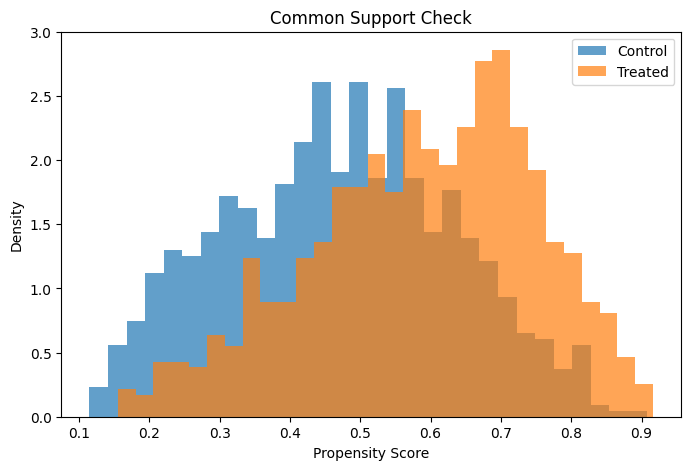

Common support: [0.155, 0.907]
DoubleML sample: 1,725 observations
DoubleML Results:
  ATE: -0.0035 (SE: 0.0804)
  95% CI: [-0.1611, 0.1542]
  p-value: 0.9655

--- SINGAPORE ---


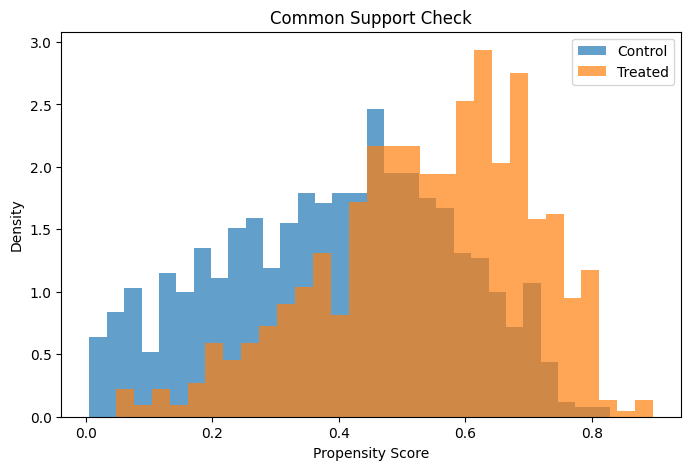

Common support: [0.047, 0.829]
DoubleML sample: 1,653 observations
DoubleML Results:
  ATE: -0.0167 (SE: 0.0562)
  95% CI: [-0.1269, 0.0935]
  p-value: 0.7662

--- PAKISTAN ---


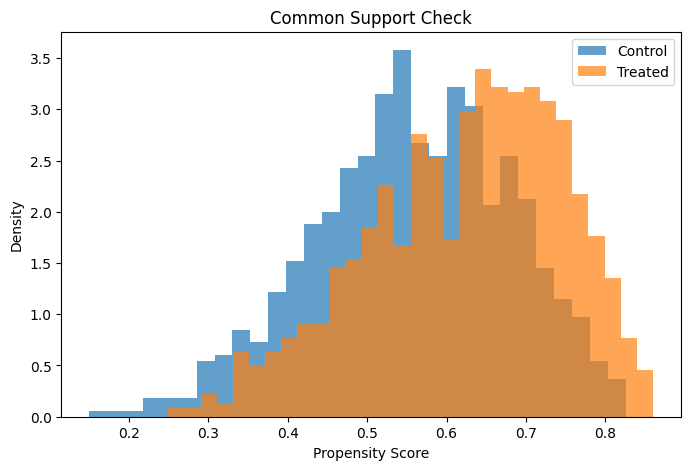

Common support: [0.250, 0.825]
DoubleML sample: 1,796 observations
DoubleML Results:
  ATE: -0.1893 (SE: 0.0802)
  95% CI: [-0.3465, -0.0322]
  p-value: 0.0182

--- AUSTRALIA ---


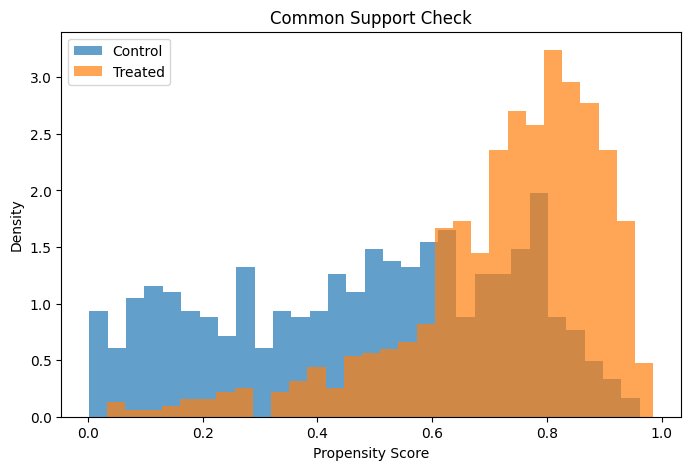

Common support: [0.034, 0.962]
DoubleML sample: 1,530 observations
DoubleML Results:
  ATE: 0.0711 (SE: 0.0897)
  95% CI: [-0.1047, 0.2468]
  p-value: 0.4282

--- RUSSIA ---


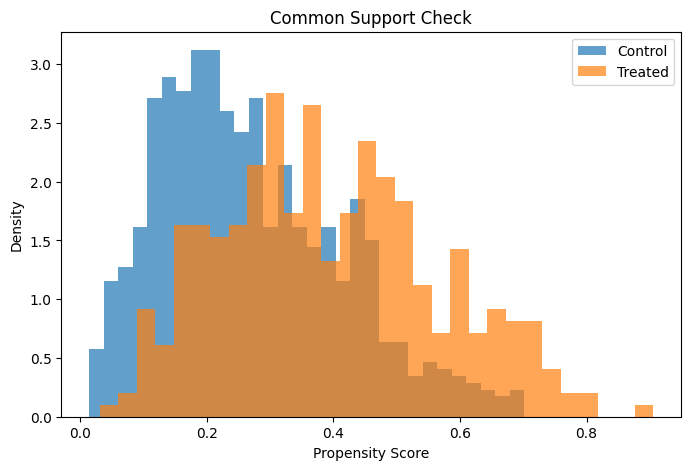

Common support: [0.031, 0.702]
DoubleML sample: 1,071 observations
DoubleML Results:
  ATE: -0.0237 (SE: 0.0869)
  95% CI: [-0.1940, 0.1466]
  p-value: 0.7853

--- BRAZIL ---


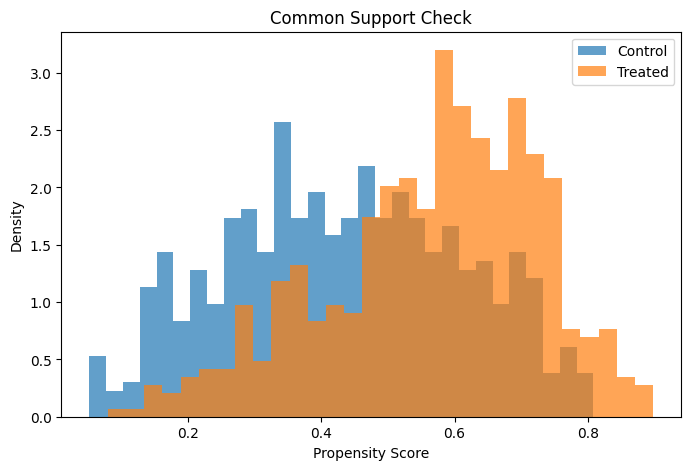

Common support: [0.079, 0.809]
DoubleML sample: 1,023 observations
DoubleML Results:
  ATE: 0.0134 (SE: 0.0908)
  95% CI: [-0.1646, 0.1913]
  p-value: 0.8830

--- MEXICO ---


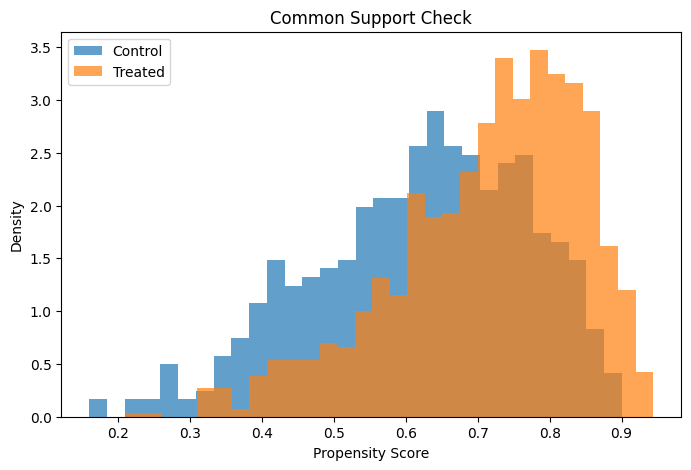

Common support: [0.212, 0.900]
DoubleML sample: 1,500 observations
DoubleML Results:
  ATE: 0.0758 (SE: 0.0909)
  95% CI: [-0.1024, 0.2539]
  p-value: 0.4047

Country Comparison Summary:
      Country    N Treatment_Rate  Effect_Size  P_Value Common_Support  Support_Width Low_Overlap Significant
       Canada 3956          52.0%       -0.002    0.960      0.03–0.95          0.922         Yes          No
    Indonesia 2665          58.5%        0.054    0.342      0.16–0.88          0.722          No          No
        China 2900          52.1%        0.016    0.572      0.06–0.88          0.817          No          No
United States 2443          52.1%        0.076    0.238      0.01–0.89          0.883         Yes          No
       Turkey 1894          37.1%       -0.212    0.000      0.07–0.80          0.723          No         Yes
  Netherlands 1345          63.9%       -0.126    0.257      0.01–0.92          0.912         Yes          No
Hong Kong SAR 1862          35.8%        0.

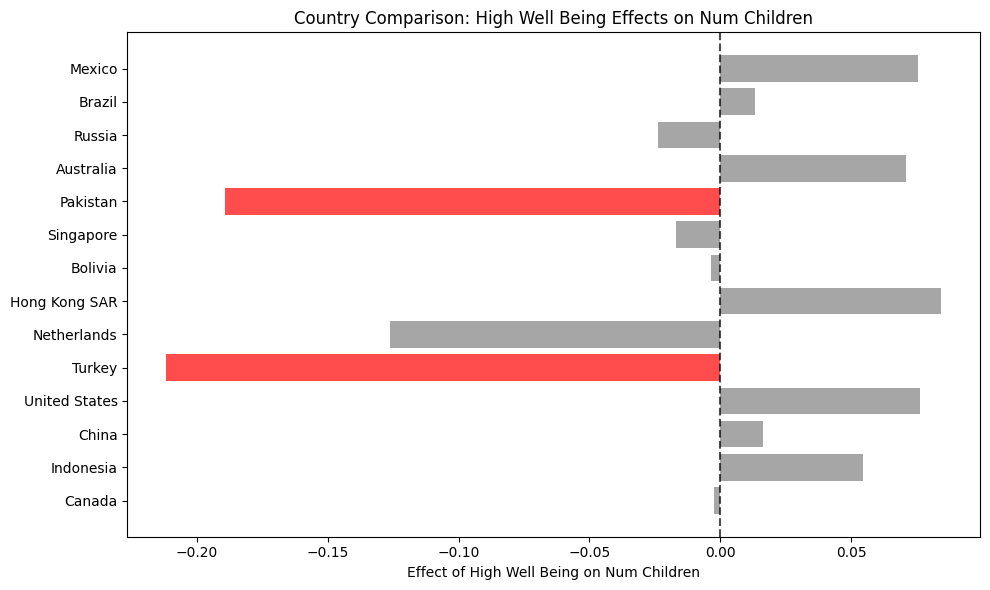

In [80]:
#well being index
pooled_results = treatment_analysis(df, treatment_var='high_well_being', outcome_var='num_children')
pooled_df = pooled_results['filtered_data'] 

pooled_df.to_csv("data/sensitivity_data/pooled_happy_data.csv", index=False)


#each country analysis
country_results, summary_df = country_comparison(df, treatment_var='high_well_being', outcome_var='num_children')

for country_name, res in country_results.items():
    country_df = res['data']
    safe_name = country_name.replace(" ", "_").replace("/", "_")
    country_df.to_csv(f"data/sensitivity_data/countries/happy/country_happy_{safe_name}_analysis.csv", index=False)

#summary table
summary_df.to_csv("data/sensitivity_data/country_happy_analysis_summary.csv", index=False)